In [1]:
# Import spacy (with fallback for Google Colab)
!pip install spacy
import spacy
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    import spacy.cli
    print("Model not found. Downloading.")
    spacy.cli.download("en_core_web_md")
    import en_core_web_md
    nlp = en_core_web_md.load()

# 1. Imports

In [2]:
import os, json, gzip 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import string
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords
stop_words = stopwords.words("english")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
RAND_SEED = 123

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/vickywang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vickywang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vickywang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/vickywang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/vickywang/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vickywang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
!pip install wordcloud

In [4]:
import importlib
if importlib.util.find_spec('flair') is None:
    !pip install flair==0.10
    
import flair
from flair.data import Sentence
from flair.embeddings import WordEmbeddings, ELMoEmbeddings, TransformerWordEmbeddings, TransformerDocumentEmbeddings, DocumentPoolEmbeddings

In [5]:
def plotConfusionMatrix(cm):
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=1)*100
    
    #create confusion matrix heat map
    f, axes = plt.subplots(figsize=(10,5))
    im = axes.imshow(cm, interpolation="nearest", cmap=plt.cm.Reds)
    
    axes.figure.colorbar(im, ax=axes)
    axes.set(title="Confusion Matrix", \
         xticks=np.arange(cm.shape[1]), \
         yticks=np.arange(cm.shape[0]), \
         xticklabels=range(-1, 2), yticklabels=range(-1, 2), \
         xlabel="Predicted", ylabel="Truth")
    
    #add clear annotations to the confusion matrix
    threshold = cm.max()/1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes.text(j, i, f"{cm[i, j]:.1f}%",
                ha="center", va="center",
                color="white" if cm[i, j] > threshold else "black")
    f.tight_layout()
    plt.show()

# 2. Load the Dataset

In [6]:
# Load the dataset
data = pd.read_csv('amazon_reviews_us_Video_Games_v1_00.tsv',sep='\t',error_bad_lines=False)

b'Skipping line 20630: expected 15 fields, saw 22\nSkipping line 28172: expected 15 fields, saw 22\nSkipping line 54791: expected 15 fields, saw 22\n'
b'Skipping line 75419: expected 15 fields, saw 22\nSkipping line 104832: expected 15 fields, saw 22\n'
b'Skipping line 138464: expected 15 fields, saw 22\nSkipping line 194849: expected 15 fields, saw 22\n'
b'Skipping line 201568: expected 15 fields, saw 22\nSkipping line 242567: expected 15 fields, saw 22\n'
b'Skipping line 493585: expected 15 fields, saw 22\nSkipping line 502478: expected 15 fields, saw 22\n'
b'Skipping line 660750: expected 15 fields, saw 22\n'


In [7]:
# Display the brief information of the Amazon Review dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780268 entries, 0 to 1780267
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   marketplace        object
 1   customer_id        int64 
 2   review_id          object
 3   product_id         object
 4   product_parent     int64 
 5   product_title      object
 6   product_category   object
 7   star_rating        int64 
 8   helpful_votes      int64 
 9   total_votes        int64 
 10  vine               object
 11  verified_purchase  object
 12  review_headline    object
 13  review_body        object
 14  review_date        object
dtypes: int64(5), object(10)
memory usage: 203.7+ MB


In [8]:
# Display top five rows of reviews
pd.options.display.max_colwidth = 500
data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that you can twist ...,"Used this for Elite Dangerous on my mac, an amazing joystick. I especially love that you can twist the stick for different movement bindings as well as move it in the normal way.",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gaming Mouse For PC Laptop Gamer Red,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single click was heard,"Loved it, I didn't even realise it was a gaming mouse, I typed in &#34;silent mouse&#34; and selected this one. It is perfect and looks pretty cool as well. Now my boyfriend's gaming is wonderfully comfortably silent :) . Think I might just get one for myself.",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fateful Voyage,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation 4 and PlayStation 3,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in intense (hard pressed) gaming sessions.",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super Smash Bros Series),Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality material to be desired, since its not perfect.",2015-08-31


## Group Similar Sentiments

In [9]:
df = data[["product_id","product_title","star_rating","review_headline","review_body","review_date"]]

In [10]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1
    
# Map stars to sentiment into three categories
df['star_rating'] = [map_sentiment(x) for x in df['star_rating']]

# Display the new rating
df.head()

,product_id,product_title,star_rating,review_headline,review_body,review_date
0,B001CXYMFS,Thrustmaster T-Flight Hotas X Flight Stick,1,an amazing joystick. I especially love that you can twist ...,"Used this for Elite Dangerous on my mac, an amazing joystick. I especially love that you can twist the stick for different movement bindings as well as move it in the normal way.",2015-08-31
1,B00M920ND6,Tonsee 6 buttons Wireless Optical Silent Gaming Mouse For PC Laptop Gamer Red,1,Definitely a silent mouse... Not a single click was heard,"Loved it, I didn't even realise it was a gaming mouse, I typed in &#34;silent mouse&#34; and selected this one. It is perfect and looks pretty cool as well. Now my boyfriend's gaming is wonderfully comfortably silent :) . Think I might just get one for myself.",2015-08-31
2,B0029CSOD2,Hidden Mysteries: Titanic Secrets of the Fateful Voyage,-1,One Star,poor quality work and not as it is advertised.,2015-08-31
3,B00GOOSV98,GelTabz Performance Thumb Grips - PlayStation 4 and PlayStation 3,0,"good, but could be bettee","nice, but tend to slip away from stick in intense (hard pressed) gaming sessions.",2015-08-31
4,B00Y074JOM,Zero Suit Samus amiibo - Japan Import (Super Smash Bros Series),1,Great but flawed.,"Great amiibo, great for collecting. Quality material to be desired, since its not perfect.",2015-08-31


In [11]:
# Count the number of reviews in each sentiment class
df.star_rating.value_counts()

 1    1340627
-1     286190
 0     153451
Name: star_rating, dtype: int64

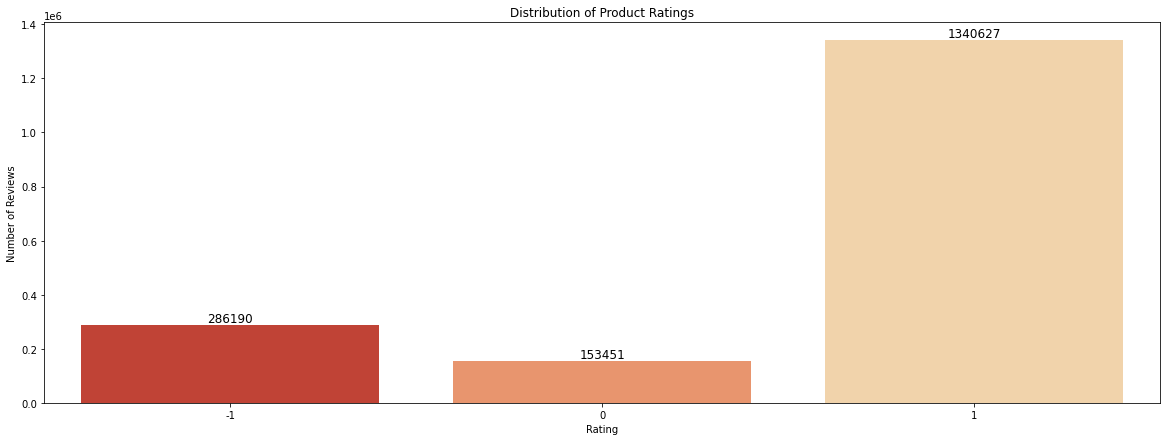

In [12]:
# Plot the distribution of product ratings
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=df["star_rating"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Rating", ylabel="Number of Reviews")

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')
    
plt.show();

From the figure above, we can see that in general, video games products perform well because it is obvious that the number of positive reviews is many times more than the number of negative and neutral reviews.

# 3. Data Pre-processing

## Data Cleaning

In [13]:
# Remove '<br />', '<BR>', '&#34;uk&#34;'
df['review_body'] = df['review_body'].str.replace('<br />',' ')
df['review_body'] = df['review_body'].str.replace('<BR>',' ')
df['review_body'] = df['review_body'].str.replace('&#34;uk&#34;',' ')
df['review_body'] = df['review_body'].str.replace('&#34',' ')
df['review_body'] = df['review_body'].str.replace('&quot',' ')


# Drop review_body that is null
df = df.dropna()

# Display the dataset
df

,product_id,product_title,star_rating,review_headline,review_body,review_date
0,B001CXYMFS,Thrustmaster T-Flight Hotas X Flight Stick,1,an amazing joystick. I especially love that you can twist ...,"Used this for Elite Dangerous on my mac, an amazing joystick. I especially love that you can twist the stick for different movement bindings as well as move it in the normal way.",2015-08-31
1,B00M920ND6,Tonsee 6 buttons Wireless Optical Silent Gaming Mouse For PC Laptop Gamer Red,1,Definitely a silent mouse... Not a single click was heard,"Loved it, I didn't even realise it was a gaming mouse, I typed in ;silent mouse ; and selected this one. It is perfect and looks pretty cool as well. Now my boyfriend's gaming is wonderfully comfortably silent :) . Think I might just get one for myself.",2015-08-31
2,B0029CSOD2,Hidden Mysteries: Titanic Secrets of the Fateful Voyage,-1,One Star,poor quality work and not as it is advertised.,2015-08-31
3,B00GOOSV98,GelTabz Performance Thumb Grips - PlayStation 4 and PlayStation 3,0,"good, but could be bettee","nice, but tend to slip away from stick in intense (hard pressed) gaming sessions.",2015-08-31
4,B00Y074JOM,Zero Suit Samus amiibo - Japan Import (Super Smash Bros Series),1,Great but flawed.,"Great amiibo, great for collecting. Quality material to be desired, since its not perfect.",2015-08-31
...,...,...,...,...,...,...
1780263,B00000JL6V,Riven: The Sequel to Myst,1,&quot;Riven&quot; generally lives up to its billing,"I don't think it is necessary for me to wax poetic about the beautifully rendered graphics that appears in ;Riven ;. Those who have seen Myst will expect them, and ;Riven ; doesn't disappoint. The live action sequences, especially the haunting scenes of natives relatively early in the game, are well done, and serve to draw you into Riven even more than Myst. (It is interesting to see the remarkable progression of the quality of the graphics from ;Spelunx ; to ;Myst ; to ;Riven ;) The p...",1997-11-09
1780264,B00000JL6V,Riven: The Sequel to Myst,1,An Immersive Experience - A Work of Art,"If I could rate higher than a ten I would. This is truly what I believe computer gaming should be like, the integration of beautiful (hand drawn) artwork that immerses you completely into a self-paced surreal world, the world of Riven These graphics! The good people at Cyan are not just game designers, they are accomplished artists. The box says that 100mhz with 4x cd-rom is required, but the artwork involved in every scene is very intricate (read: realistic) so have patience at those spe...",1997-11-09
1780265,B00000JL6V,Riven: The Sequel to Myst,-1,Riven - or Driven by Microsoft?,"Fewer than 1 in 3 modern Windows computers are running Windows 95. How about the rest of us who aren't inclined to be pushed into another operating system? It's too bad. But I won't be buying a copy of this one, even though I thoroughly enjoyed Myst.",1997-11-08
1780266,B00000JL6V,Riven: The Sequel to Myst,-1,Disappointment !!!,Unfortunately Riven is available only to those privilidged few who have the newest and the fastest hardware on the market. Maybe a future release will be more sensitive to the less wealthy and privilidged. I'm disappointed!,1997-11-06


## Visualise Word Count Distribution

In [14]:
# split into list
df['splitted_words'] = df.review_body.str.split(' ')

df['word_count'] = df['splitted_words'].apply(len)

df

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count
0,B001CXYMFS,Thrustmaster T-Flight Hotas X Flight Stick,1,an amazing joystick. I especially love that you can twist ...,"Used this for Elite Dangerous on my mac, an amazing joystick. I especially love that you can twist the stick for different movement bindings as well as move it in the normal way.",2015-08-31,"[Used, this, for, Elite, Dangerous, on, my, mac,, an, amazing, joystick., I, especially, love, that, you, can, twist, the, stick, for, different, movement, bindings, as, well, as, move, it, in, the, normal, way.]",33
1,B00M920ND6,Tonsee 6 buttons Wireless Optical Silent Gaming Mouse For PC Laptop Gamer Red,1,Definitely a silent mouse... Not a single click was heard,"Loved it, I didn't even realise it was a gaming mouse, I typed in ;silent mouse ; and selected this one. It is perfect and looks pretty cool as well. Now my boyfriend's gaming is wonderfully comfortably silent :) . Think I might just get one for myself.",2015-08-31,"[Loved, it,, , I, didn't, even, realise, it, was, a, gaming, mouse,, , I, typed, in, , ;silent, mouse, ;, and, selected, this, one., It, is, perfect, and, looks, pretty, cool, as, well., Now, my, boyfriend's, gaming, is, wonderfully, comfortably, silent, :), ., Think, I, might, just, get, one, for, myself.]",51
2,B0029CSOD2,Hidden Mysteries: Titanic Secrets of the Fateful Voyage,-1,One Star,poor quality work and not as it is advertised.,2015-08-31,"[poor, quality, work, and, not, as, it, is, advertised.]",9
3,B00GOOSV98,GelTabz Performance Thumb Grips - PlayStation 4 and PlayStation 3,0,"good, but could be bettee","nice, but tend to slip away from stick in intense (hard pressed) gaming sessions.",2015-08-31,"[nice,, but, tend, to, slip, away, from, stick, in, intense, (hard, pressed), gaming, sessions.]",14
4,B00Y074JOM,Zero Suit Samus amiibo - Japan Import (Super Smash Bros Series),1,Great but flawed.,"Great amiibo, great for collecting. Quality material to be desired, since its not perfect.",2015-08-31,"[Great, amiibo,, great, for, collecting., Quality, material, to, be, desired,, since, its, not, perfect.]",14
...,...,...,...,...,...,...,...,...
1780263,B00000JL6V,Riven: The Sequel to Myst,1,&quot;Riven&quot; generally lives up to its billing,"I don't think it is necessary for me to wax poetic about the beautifully rendered graphics that appears in ;Riven ;. Those who have seen Myst will expect them, and ;Riven ; doesn't disappoint. The live action sequences, especially the haunting scenes of natives relatively early in the game, are well done, and serve to draw you into Riven even more than Myst. (It is interesting to see the remarkable progression of the quality of the graphics from ;Spelunx ; to ;Myst ; to ;Riven ;) The p...",1997-11-09,"[I, don't, think, it, is, necessary, for, me, to, wax, poetic, about, the, beautifully, rendered, graphics, that, appears, in, , ;Riven, ;., Those, who, have, seen, Myst, will, expect, them,, and, , ;Riven, ;, doesn't, disappoint., The, live, action, sequences,, especially, the, haunting, scenes, of, natives, relatively, early, in, the, game,, are, well, done,, and, serve, to, draw, you, into, Riven, even, more, than, Myst., (It, is, interesting, to, see, the, remarkable, progression, of, th...",157
1780264,B00000JL6V,Riven: The Sequel to Myst,1,An Immersive Experience - A Work of Art,"If I could rate higher than a ten I would. This is truly what I believe computer gaming should be like, the integration of beautiful (hand drawn) artwork that immerses you completely into a self-paced surreal world, the world of Riven These graphics! The good people at Cyan are not just game designers, they are accomplished artists. The box says that 100mhz with 4x cd-rom is required, but the artwork involved in every scene is very intricate (read: realistic) so have patience at those spe...",1997-11-09,"[If, I, could, rate, higher, than, a, ten, I, would., This, is, truly,

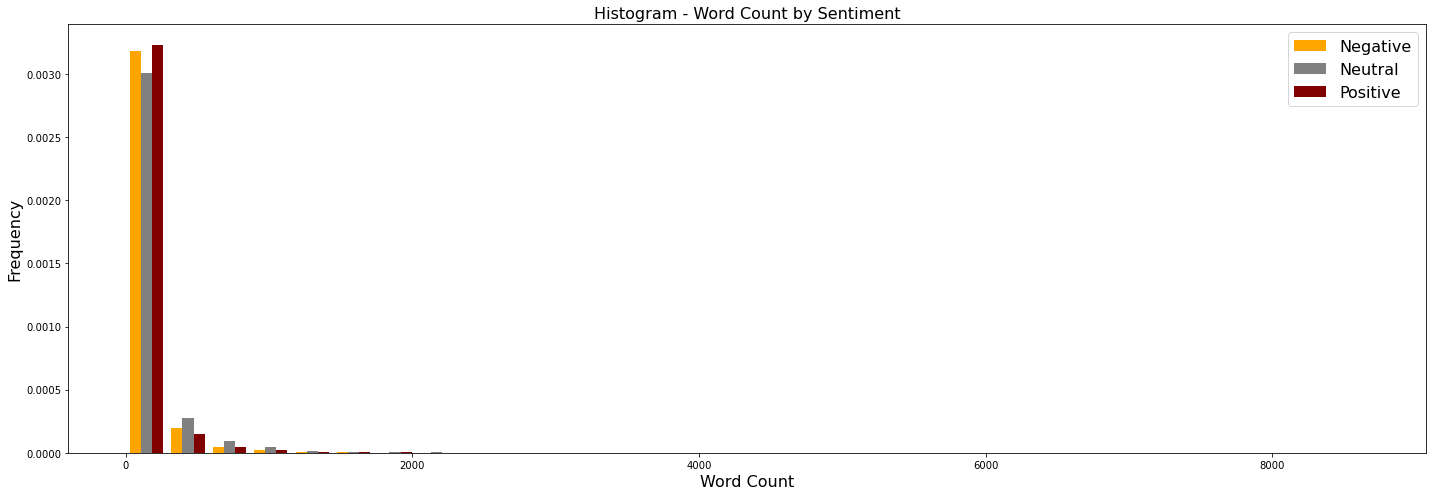

In [256]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(20,7))

n_bins = 30

colors = ['orange', 'grey', 'maroon']

x_multi = [df[df['star_rating'] == -1]['word_count'],df[df['star_rating'] == 0]['word_count'],
          df[df['star_rating'] == 1]['word_count']]
ax.hist(x_multi, n_bins, histtype='bar', color=colors, density=True)
ax.set_title('Histogram - Word Count by Sentiment', fontsize=16)
ax.legend(['Negative', 'Neutral','Positive'], fontsize=16)

plt.xlabel('Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

fig.tight_layout()
plt.show();

Neutral reviews tend to be longer than negative and positive reviews, while negative reviews are usually longer than positive reviews, as mentioned by previous researchers.

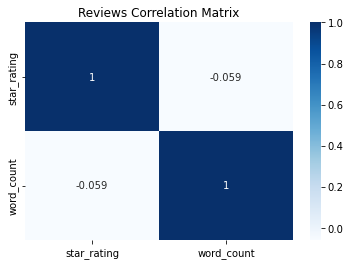

In [206]:
# Create heatmap to see the correlation between sentiment and review length
corr = df[['star_rating','word_count']].corr()
sns.heatmap(corr, cmap=plt.cm.Blues, annot=True)
plt.title('Reviews Correlation Matrix')
plt.show();

Word count and star rating have a negative correlation. The longer the review, the lower the star rating.

## Remove Capitalisation

In [16]:
# Replace review body with all lowercase characters
df['review_body'] = df.review_body.str.lower()
df.tail()

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count
1780263,B00000JL6V,Riven: The Sequel to Myst,1,&quot;Riven&quot; generally lives up to its billing,"i don't think it is necessary for me to wax poetic about the beautifully rendered graphics that appears in ;riven ;. those who have seen myst will expect them, and ;riven ; doesn't disappoint. the live action sequences, especially the haunting scenes of natives relatively early in the game, are well done, and serve to draw you into riven even more than myst. (it is interesting to see the remarkable progression of the quality of the graphics from ;spelunx ; to ;myst ; to ;riven ;) the p...",1997-11-09,"[I, don't, think, it, is, necessary, for, me, to, wax, poetic, about, the, beautifully, rendered, graphics, that, appears, in, , ;Riven, ;., Those, who, have, seen, Myst, will, expect, them,, and, , ;Riven, ;, doesn't, disappoint., The, live, action, sequences,, especially, the, haunting, scenes, of, natives, relatively, early, in, the, game,, are, well, done,, and, serve, to, draw, you, into, Riven, even, more, than, Myst., (It, is, interesting, to, see, the, remarkable, progression, of, th...",157
1780264,B00000JL6V,Riven: The Sequel to Myst,1,An Immersive Experience - A Work of Art,"if i could rate higher than a ten i would. this is truly what i believe computer gaming should be like, the integration of beautiful (hand drawn) artwork that immerses you completely into a self-paced surreal world, the world of riven these graphics! the good people at cyan are not just game designers, they are accomplished artists. the box says that 100mhz with 4x cd-rom is required, but the artwork involved in every scene is very intricate (read: realistic) so have patience at those spe...",1997-11-09,"[If, I, could, rate, higher, than, a, ten, I, would., This, is, truly, what, I, believe, computer, gaming, should, be, like,, the, integration, of, beautiful, (hand, drawn), artwork, that, immerses, you, completely, into, a, self-paced, surreal, world,, the, world, of, Riven, , , These, graphics!, The, good, people, at, Cyan, are, not, just, game, designers,, they, are, accomplished, artists., The, box, says, that, 100mhz, with, 4x, cd-rom, is, required,, but, the, artwork, involved, in, eve...",177
1780265,B00000JL6V,Riven: The Sequel to Myst,-1,Riven - or Driven by Microsoft?,"fewer than 1 in 3 modern windows computers are running windows 95. how about the rest of us who aren't inclined to be pushed into another operating system? it's too bad. but i won't be buying a copy of this one, even though i thoroughly enjoyed myst.",1997-11-08,"[Fewer, than, 1, in, 3, modern, Windows, computers, are, running, Windows, 95., How, about, the, rest, of, us, who, aren't, inclined, to, be, pushed, into, another, operating, system?, , It's, too, bad., But, I, won't, be, buying, a, copy, of, this, one,, even, though, I, thoroughly, enjoyed, Myst.]",48
1780266,B00000JL6V,Riven: The Sequel to Myst,-1,Disappointment !!!,unfortunately riven is available only to those privilidged few who have the newest and the fastest hardware on the market. maybe a future release will be more sensitive to the less wealthy and privilidged. i'm disappointed!,1997-11-06,"[Unfortunately, Riven, is, available, only, to, those, privilidged, few, who, have, the, newest, and, the, fastest, hardware, on, the, market., Maybe, a, future, release, will, be, more, sensitive, to, the, less, wealthy, and, privilidged., I'm, disappointed!]",36
1780267,B00000JL6V,Riven: The Sequel to Myst,1,Engulfed in Wonder,"if you are brave enough to buy the game, do the following: buy an answering machine, cancel your appointments, call in sick, lock the door, warm up some tea of coffee, install the game and hang on. riven's wonder surrounds you in a matter of seconds. the detail, the music and the story keeps you breathless. but have no doubt that puzzles are challenging. if it becomes frustrating, just do this

## Sampling

Since we have limited processing power, we will do NLP-related pre-processing using a smaller set of data.

In [17]:
# Make a copy of 'df'
sample_df = df.copy()

# Sort the dataframe by 'review_date' so that we only pick the most recent reviews for the analysis
sample_df = sample_df.sort_values(by=['review_date'], ascending=False)

# Set sample size
sample_size = 16000
sample_df2 = pd.DataFrame()
for i in sample_df.star_rating.unique():
    X = sample_df[sample_df.star_rating == i].sample(sample_size)
    sample_df2 = sample_df2.append(X)
sample_df2

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count
73850,B00KWG4HG0,Mario Party 10,1,Four Stars,not as good as mario party 9 but it's a fun family game.,2015-06-28,"[Not, as, good, as, Mario, Party, 9, but, it's, a, fun, family, game.]",13
1560918,B00006FWUU,Sony Playstation 2 Dualshock 2 Analog Wired Controller SCPH-10010 - Ocean Blue,1,it's a controller,"in case you havent' noticed this is a controller not a game. so as far as the controller goes, it works great and i have not had a single problem with it.",2006-06-26,"[In, case, you, havent', noticed, this, is, a, controller, not, a, game., So, as, far, as, the, controller, goes,, it, works, great, and, I, have, not, had, a, single, problem, with, it.]",32
444662,B00IGXR2JK,"Mad Catz TRITTON Kunai Stereo Headset for PlayStation 4, PlayStation 3 and PlayStation Vita",1,I recommend,"really good value for money. i didn't have high hopes for it due to the price, but i'm really happy with what i've got.",2014-10-11,"[Really, good, value, for, money., I, didn't, have, high, hopes, for, it, due, to, the, price,, but, I'm, really, happy, with, what, I've, got.]",24
640262,B00BMFIXZG,Assassin's Creed 4,1,black flag,"so far it is pretty good, more fun than assassin's creed 3. on the ship is fun always wanted to be on a ship and loot other ships, and fight like in the movies.",2014-03-10,"[So, far, it, is, pretty, good,, more, fun, than, assassin's, Creed, 3., On, the, ship, is, fun, always, wanted, to, be, on, a, ship, and, loot, other, ships,, and, fight, like, in, the, movies.]",34
1102594,B006JKARN0,PS3 Gran Turismo 5 XL Edition,1,yobder,"muy buena compra muy buen juego me gusta se ve casi real las imagenes, hay que saberlo jugar lo recomiendo",2012-06-29,"[muy, buena, compra, muy, buen, juego, me, gusta, se, ve, casi, real, las, imagenes,, hay, que, saberlo, jugar, , lo, recomiendo]",21
...,...,...,...,...,...,...,...,...
382741,B000VB56XO,Alvin & The Chipmunks,0,Three Stars,ok as bought for the grand kids and am grateful i was not around to hear it.,2014-12-02,"[Ok, as, bought, for, the, grand, kids, and, am, grateful, I, was, not, around, to, hear, it.]",17
1326081,B000046S41,Nintendo 64 Transfer Pak,0,N64 transfer pak,"came fast, its almost new condition, havent had any problems...will recommend this seller to others.",2010-07-16,"[Came, fast,, ITs, almost, new, condition,, havent, had, any, problems...will, recommend, this, seller, to, others.]",15
1505578,B000FQBWAG,Excite Truck - Nintendo Wii,0,Beware this game,"if you got a wii for christmas with only the included wii sports or with the wii play package, excite truck could create household issues. the bottom line is that this game is lots of fun. in fact, it's a whole lot more fun than the basic wii games, which will mean that your kids won't really find the basic wii games to be all that interesting anymore. they'll just want to race. that may be just fine with you. but if you got the wii because you wanted a video game that was more active a...",2007-12-27,"[If, you, got, a, Wii, for, Christmas, with, only, the, included, Wii, sports, or, with, the, Wii, Play, package,, Excite, Truck, could, create, household, issues., , The, bottom, line, is, that, this, game, is, lots, of, fun., , In, fact,, it's, a, whole, lot, more, fun, than, the, basic, Wii, games,, which, will, mean, that, your, kids, won't, really, find, the, basic, Wii, games, to, be, all, that, interesting, anymore., , They'll, just, want, to, race., , That, may, be, just, fine, with,...",129
1196814,B0034ZOAO0,Tomee SNES USB Controller for PC/ Mac,0,Definitely Lacks the Quality Feel of the Original,"this controller gets the job done. it works fine and i prefer it to the original in that it does not require a usb adapter. the d-pad is the only thing that sort of irks me. when i first load up a game it registers a constant right d-pad button press. if i roll my thumb around on the d-pad for a few seconds the p

In [18]:
# Count the number of reviews in each sentiment class
sample_df2.star_rating.value_counts()

 1    16000
-1    16000
 0    16000
Name: star_rating, dtype: int64

## Tokenization

In [19]:
def tokenize_review(review):
    # create a doc object using spaCy
    doc = nlp(review)
    # create a list of tokens for the review
    tokens = [token.text for token in doc]
    return tokens

sample_df2['tokens'] = sample_df2['review_body'].apply(tokenize_review)


In [20]:
sample_df2['token_count'] = sample_df2['tokens'].apply(len)

In [21]:
sample_df2.head()

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count,tokens,token_count
73850,B00KWG4HG0,Mario Party 10,1,Four Stars,not as good as mario party 9 but it's a fun family game.,2015-06-28,"[Not, as, good, as, Mario, Party, 9, but, it's, a, fun, family, game.]",13,"[not, as, good, as, mario, party, 9, but, it, 's, a, fun, family, game, .]",15
1560918,B00006FWUU,Sony Playstation 2 Dualshock 2 Analog Wired Controller SCPH-10010 - Ocean Blue,1,it's a controller,"in case you havent' noticed this is a controller not a game. so as far as the controller goes, it works great and i have not had a single problem with it.",2006-06-26,"[In, case, you, havent', noticed, this, is, a, controller, not, a, game., So, as, far, as, the, controller, goes,, it, works, great, and, I, have, not, had, a, single, problem, with, it.]",32,"[in, case, you, have, nt, ', noticed, this, is, a, controller, not, a, game, ., so, as, far, as, the, controller, goes, ,, it, works, great, and, i, have, not, had, a, single, problem, with, it, .]",37
444662,B00IGXR2JK,"Mad Catz TRITTON Kunai Stereo Headset for PlayStation 4, PlayStation 3 and PlayStation Vita",1,I recommend,"really good value for money. i didn't have high hopes for it due to the price, but i'm really happy with what i've got.",2014-10-11,"[Really, good, value, for, money., I, didn't, have, high, hopes, for, it, due, to, the, price,, but, I'm, really, happy, with, what, I've, got.]",24,"[really, good, value, for, money, ., i, did, n't, have, high, hopes, for, it, due, to, the, price, ,, but, i, 'm, really, happy, with, what, i, 've, got, .]",30
640262,B00BMFIXZG,Assassin's Creed 4,1,black flag,"so far it is pretty good, more fun than assassin's creed 3. on the ship is fun always wanted to be on a ship and loot other ships, and fight like in the movies.",2014-03-10,"[So, far, it, is, pretty, good,, more, fun, than, assassin's, Creed, 3., On, the, ship, is, fun, always, wanted, to, be, on, a, ship, and, loot, other, ships,, and, fight, like, in, the, movies.]",34,"[so, far, it, is, pretty, good, ,, more, fun, than, assassin, 's, creed, 3, ., on, the, ship, is, fun, always, wanted, to, be, on, a, ship, and, loot, other, ships, ,, and, fight, like, in, the, movies, .]",39
1102594,B006JKARN0,PS3 Gran Turismo 5 XL Edition,1,yobder,"muy buena compra muy buen juego me gusta se ve casi real las imagenes, hay que saberlo jugar lo recomiendo",2012-06-29,"[muy, buena, compra, muy, buen, juego, me, gusta, se, ve, casi, real, las, imagenes,, hay, que, saberlo, jugar, , lo, recomiendo]",21,"[muy, buena, compra, muy, buen, juego, me, gusta, se, ve, casi, real, las, imagenes, ,, hay, que, saberlo, jugar, , lo, recomiendo]",22


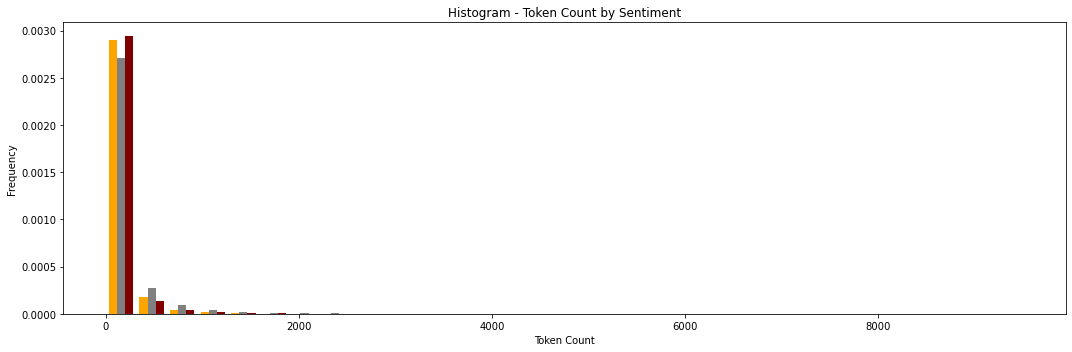

In [22]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,5))

n_bins = 30

colors = ['orange', 'grey', 'maroon']

x_multi = [sample_df2[sample_df2['star_rating'] == -1]['token_count'],sample_df2[sample_df2['star_rating'] == 0]['token_count'],
          sample_df2[sample_df2['star_rating'] == 1]['token_count']]
ax.hist(x_multi, n_bins, histtype='bar', color=colors, density=True)
ax.set_title('Histogram - Token Count by Sentiment')

plt.xlabel('Token Count')
plt.ylabel('Frequency')

fig.tight_layout()
plt.show();

After tokenization, we plotted a histogram for token count by sentiment, which showed a similar pattern as the one for word count. Negative reviews are generally longer than positive reviews as expected, while neutral reviews are still the longest in general.

## Stopwords Removal

In [23]:
# Remove stopwords
from spacy.lang.en.stop_words import STOP_WORDS

len(STOP_WORDS)

326

In [24]:
# Define a function to remove stopwords

def remove_sw(review):
    token_list = [word.text for word in review]
    tokens_without_sw = [word for word in token_list if word not in STOP_WORDS]
    return tokens_without_sw

# apply the function to every row in the 'tokens' column
sample_df2['tokens_nosw'] = sample_df2['review_body'].apply(lambda x: remove_sw(nlp(x)))

# Display 'sample_df2'
sample_df2

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count,tokens,token_count,tokens_nosw
73850,B00KWG4HG0,Mario Party 10,1,Four Stars,not as good as mario party 9 but it's a fun family game.,2015-06-28,"[Not, as, good, as, Mario, Party, 9, but, it's, a, fun, family, game.]",13,"[not, as, good, as, mario, party, 9, but, it, 's, a, fun, family, game, .]",15,"[good, mario, party, 9, fun, family, game, .]"
1560918,B00006FWUU,Sony Playstation 2 Dualshock 2 Analog Wired Controller SCPH-10010 - Ocean Blue,1,it's a controller,"in case you havent' noticed this is a controller not a game. so as far as the controller goes, it works great and i have not had a single problem with it.",2006-06-26,"[In, case, you, havent', noticed, this, is, a, controller, not, a, game., So, as, far, as, the, controller, goes,, it, works, great, and, I, have, not, had, a, single, problem, with, it.]",32,"[in, case, you, have, nt, ', noticed, this, is, a, controller, not, a, game, ., so, as, far, as, the, controller, goes, ,, it, works, great, and, i, have, not, had, a, single, problem, with, it, .]",37,"[case, nt, ', noticed, controller, game, ., far, controller, goes, ,, works, great, single, problem, .]"
444662,B00IGXR2JK,"Mad Catz TRITTON Kunai Stereo Headset for PlayStation 4, PlayStation 3 and PlayStation Vita",1,I recommend,"really good value for money. i didn't have high hopes for it due to the price, but i'm really happy with what i've got.",2014-10-11,"[Really, good, value, for, money., I, didn't, have, high, hopes, for, it, due, to, the, price,, but, I'm, really, happy, with, what, I've, got.]",24,"[really, good, value, for, money, ., i, did, n't, have, high, hopes, for, it, due, to, the, price, ,, but, i, 'm, really, happy, with, what, i, 've, got, .]",30,"[good, value, money, ., high, hopes, price, ,, happy, got, .]"
640262,B00BMFIXZG,Assassin's Creed 4,1,black flag,"so far it is pretty good, more fun than assassin's creed 3. on the ship is fun always wanted to be on a ship and loot other ships, and fight like in the movies.",2014-03-10,"[So, far, it, is, pretty, good,, more, fun, than, assassin's, Creed, 3., On, the, ship, is, fun, always, wanted, to, be, on, a, ship, and, loot, other, ships,, and, fight, like, in, the, movies.]",34,"[so, far, it, is, pretty, good, ,, more, fun, than, assassin, 's, creed, 3, ., on, the, ship, is, fun, always, wanted, to, be, on, a, ship, and, loot, other, ships, ,, and, fight, like, in, the, movies, .]",39,"[far, pretty, good, ,, fun, assassin, creed, 3, ., ship, fun, wanted, ship, loot, ships, ,, fight, like, movies, .]"
1102594,B006JKARN0,PS3 Gran Turismo 5 XL Edition,1,yobder,"muy buena compra muy buen juego me gusta se ve casi real las imagenes, hay que saberlo jugar lo recomiendo",2012-06-29,"[muy, buena, compra, muy, buen, juego, me, gusta, se, ve, casi, real, las, imagenes,, hay, que, saberlo, jugar, , lo, recomiendo]",21,"[muy, buena, compra, muy, buen, juego, me, gusta, se, ve, casi, real, las, imagenes, ,, hay, que, saberlo, jugar, , lo, recomiendo]",22,"[muy, buena, compra, muy, buen, juego, gusta, se, ve, casi, real, las, imagenes, ,, hay, que, saberlo, jugar, , lo, recomiendo]"
...,...,...,...,...,...,...,...,...,...,...,...
382741,B000VB56XO,Alvin & The Chipmunks,0,Three Stars,ok as bought for the grand kids and am grateful i was not around to hear it.,2014-12-02,"[Ok, as, bought, for, the, grand, kids, and, am, grateful, I, was, not, around, to, hear, it.]",17,"[ok, as, bought, for, the, grand, kids, and, am, grateful, i, was, not, around, to, hear, it, .]",18,"[ok, bought, grand, kids, grateful, hear, .]"
1326081,B000046S41,Nintendo 64 Transfer Pak,0,N64 transfer pak,"came fast, its almost new condition, havent had any problems...will recommend this seller to others.",2010-07-16,"[Came, fast,, ITs, almost, new, condition,, havent, had, any, problems...will, recommend, this, seller, to, others.]",15,"[came, fast, ,, its, almost, new, condition, ,, have

In [27]:
# Remove non-alphanumeric characters

import re

# Join the tokens without stopwords back to a string first for punctuation and non-alphanumeric removal
sample_df2['nosw_review'] = sample_df2['tokens_nosw'].apply(lambda x: " ".join(x))

# Define a regular expression to match non-alphanumeric characters
pattern = r'[^0-9a-zA-Z]+'

# Apply the regular expression to the 'tokens_nosw' column
sample_df2['nosw_pure_review'] = sample_df2['nosw_review'].apply(lambda x: re.sub(pattern, ' ', x))

# Remove leading and trailing whitespaces
sample_df2['nosw_pure_review'] = sample_df2['nosw_pure_review'].str.strip()

sample_df2

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count,tokens,token_count,tokens_nosw,nosw_review,nosw_pure_review
73850,B00KWG4HG0,Mario Party 10,1,Four Stars,not as good as mario party 9 but it's a fun family game.,2015-06-28,"[Not, as, good, as, Mario, Party, 9, but, it's, a, fun, family, game.]",13,"[not, as, good, as, mario, party, 9, but, it, 's, a, fun, family, game, .]",15,"[good, mario, party, 9, fun, family, game, .]",good mario party 9 fun family game .,good mario party 9 fun family game
1560918,B00006FWUU,Sony Playstation 2 Dualshock 2 Analog Wired Controller SCPH-10010 - Ocean Blue,1,it's a controller,"in case you havent' noticed this is a controller not a game. so as far as the controller goes, it works great and i have not had a single problem with it.",2006-06-26,"[In, case, you, havent', noticed, this, is, a, controller, not, a, game., So, as, far, as, the, controller, goes,, it, works, great, and, I, have, not, had, a, single, problem, with, it.]",32,"[in, case, you, have, nt, ', noticed, this, is, a, controller, not, a, game, ., so, as, far, as, the, controller, goes, ,, it, works, great, and, i, have, not, had, a, single, problem, with, it, .]",37,"[case, nt, ', noticed, controller, game, ., far, controller, goes, ,, works, great, single, problem, .]","case nt ' noticed controller game . far controller goes , works great single problem .",case nt noticed controller game far controller goes works great single problem
444662,B00IGXR2JK,"Mad Catz TRITTON Kunai Stereo Headset for PlayStation 4, PlayStation 3 and PlayStation Vita",1,I recommend,"really good value for money. i didn't have high hopes for it due to the price, but i'm really happy with what i've got.",2014-10-11,"[Really, good, value, for, money., I, didn't, have, high, hopes, for, it, due, to, the, price,, but, I'm, really, happy, with, what, I've, got.]",24,"[really, good, value, for, money, ., i, did, n't, have, high, hopes, for, it, due, to, the, price, ,, but, i, 'm, really, happy, with, what, i, 've, got, .]",30,"[good, value, money, ., high, hopes, price, ,, happy, got, .]","good value money . high hopes price , happy got .",good value money high hopes price happy got
640262,B00BMFIXZG,Assassin's Creed 4,1,black flag,"so far it is pretty good, more fun than assassin's creed 3. on the ship is fun always wanted to be on a ship and loot other ships, and fight like in the movies.",2014-03-10,"[So, far, it, is, pretty, good,, more, fun, than, assassin's, Creed, 3., On, the, ship, is, fun, always, wanted, to, be, on, a, ship, and, loot, other, ships,, and, fight, like, in, the, movies.]",34,"[so, far, it, is, pretty, good, ,, more, fun, than, assassin, 's, creed, 3, ., on, the, ship, is, fun, always, wanted, to, be, on, a, ship, and, loot, other, ships, ,, and, fight, like, in, the, movies, .]",39,"[far, pretty, good, ,, fun, assassin, creed, 3, ., ship, fun, wanted, ship, loot, ships, ,, fight, like, movies, .]","far pretty good , fun assassin creed 3 . ship fun wanted ship loot ships , fight like movies .",far pretty good fun assassin creed 3 ship fun wanted ship loot ships fight like movies
1102594,B006JKARN0,PS3 Gran Turismo 5 XL Edition,1,yobder,"muy buena compra muy buen juego me gusta se ve casi real las imagenes, hay que saberlo jugar lo recomiendo",2012-06-29,"[muy, buena, compra, muy, buen, juego, me, gusta, se, ve, casi, real, las, imagenes,, hay, que, saberlo, jugar, , lo, recomiendo]",21,"[muy, buena, compra, muy, buen, juego, me, gusta, se, ve, casi, real, las, imagenes, ,, hay, que, saberlo, jugar, , lo, recomiendo]",22,"[muy, buena, compra, muy, buen, juego, gusta, se, ve, casi, real, las, imagenes, ,, hay, que, saberlo, jugar, , lo, recomiendo]","muy buena compra muy buen juego gusta se ve casi real las imagenes , hay que saberlo jugar lo recomiendo",muy buena compra muy buen juego gusta se ve casi real las imagenes hay que saberlo jugar lo recomiendo
...,...,...,...,...,...,...,...,

## Stemming and Lemmatisation

In [28]:
# Define a function for lemmatisation

def lemmatise(text):
    return " ".join([token.lemma_ for token in text])

# Apply the function to every row in the column
sample_df2['afterlem_review'] = sample_df2['nosw_pure_review'].apply(lambda x: lemmatise(nlp(x)))

# Display 'sample_df2'
sample_df2

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count,tokens,token_count,tokens_nosw,nosw_review,nosw_pure_review,afterlem_review
73850,B00KWG4HG0,Mario Party 10,1,Four Stars,not as good as mario party 9 but it's a fun family game.,2015-06-28,"[Not, as, good, as, Mario, Party, 9, but, it's, a, fun, family, game.]",13,"[not, as, good, as, mario, party, 9, but, it, 's, a, fun, family, game, .]",15,"[good, mario, party, 9, fun, family, game, .]",good mario party 9 fun family game .,good mario party 9 fun family game,good mario party 9 fun family game
1560918,B00006FWUU,Sony Playstation 2 Dualshock 2 Analog Wired Controller SCPH-10010 - Ocean Blue,1,it's a controller,"in case you havent' noticed this is a controller not a game. so as far as the controller goes, it works great and i have not had a single problem with it.",2006-06-26,"[In, case, you, havent', noticed, this, is, a, controller, not, a, game., So, as, far, as, the, controller, goes,, it, works, great, and, I, have, not, had, a, single, problem, with, it.]",32,"[in, case, you, have, nt, ', noticed, this, is, a, controller, not, a, game, ., so, as, far, as, the, controller, goes, ,, it, works, great, and, i, have, not, had, a, single, problem, with, it, .]",37,"[case, nt, ', noticed, controller, game, ., far, controller, goes, ,, works, great, single, problem, .]","case nt ' noticed controller game . far controller goes , works great single problem .",case nt noticed controller game far controller goes works great single problem,case not notice controller game far controller go work great single problem
444662,B00IGXR2JK,"Mad Catz TRITTON Kunai Stereo Headset for PlayStation 4, PlayStation 3 and PlayStation Vita",1,I recommend,"really good value for money. i didn't have high hopes for it due to the price, but i'm really happy with what i've got.",2014-10-11,"[Really, good, value, for, money., I, didn't, have, high, hopes, for, it, due, to, the, price,, but, I'm, really, happy, with, what, I've, got.]",24,"[really, good, value, for, money, ., i, did, n't, have, high, hopes, for, it, due, to, the, price, ,, but, i, 'm, really, happy, with, what, i, 've, got, .]",30,"[good, value, money, ., high, hopes, price, ,, happy, got, .]","good value money . high hopes price , happy got .",good value money high hopes price happy got,good value money high hope price happy get
640262,B00BMFIXZG,Assassin's Creed 4,1,black flag,"so far it is pretty good, more fun than assassin's creed 3. on the ship is fun always wanted to be on a ship and loot other ships, and fight like in the movies.",2014-03-10,"[So, far, it, is, pretty, good,, more, fun, than, assassin's, Creed, 3., On, the, ship, is, fun, always, wanted, to, be, on, a, ship, and, loot, other, ships,, and, fight, like, in, the, movies.]",34,"[so, far, it, is, pretty, good, ,, more, fun, than, assassin, 's, creed, 3, ., on, the, ship, is, fun, always, wanted, to, be, on, a, ship, and, loot, other, ships, ,, and, fight, like, in, the, movies, .]",39,"[far, pretty, good, ,, fun, assassin, creed, 3, ., ship, fun, wanted, ship, loot, ships, ,, fight, like, movies, .]","far pretty good , fun assassin creed 3 . ship fun wanted ship loot ships , fight like movies .",far pretty good fun assassin creed 3 ship fun wanted ship loot ships fight like movies,far pretty good fun assassin creed 3 ship fun want ship loot ship fight like movie
1102594,B006JKARN0,PS3 Gran Turismo 5 XL Edition,1,yobder,"muy buena compra muy buen juego me gusta se ve casi real las imagenes, hay que saberlo jugar lo recomiendo",2012-06-29,"[muy, buena, compra, muy, buen, juego, me, gusta, se, ve, casi, real, las, imagenes,, hay, que, saberlo, jugar, , lo, recomiendo]",21,"[muy, buena, compra, muy, buen, juego, me, gusta, se, ve, casi, real, las, imagenes, ,, hay, que, saberlo, jugar, , lo, recomiendo]",22,"[muy, buena, compra, muy, buen, juego, gusta, se, ve, casi, real, las, imagenes, ,, hay, que, saberlo, jugar, , lo, re

In [29]:
# Get the tokens again from the 'tokens_lemma' column which has all the pre-processing done
sample_df2['clean_tokens'] = sample_df2.afterlem_review.str.split(' ')
sample_df2

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count,tokens,token_count,tokens_nosw,nosw_review,nosw_pure_review,afterlem_review,clean_tokens
73850,B00KWG4HG0,Mario Party 10,1,Four Stars,not as good as mario party 9 but it's a fun family game.,2015-06-28,"[Not, as, good, as, Mario, Party, 9, but, it's, a, fun, family, game.]",13,"[not, as, good, as, mario, party, 9, but, it, 's, a, fun, family, game, .]",15,"[good, mario, party, 9, fun, family, game, .]",good mario party 9 fun family game .,good mario party 9 fun family game,good mario party 9 fun family game,"[good, mario, party, 9, fun, family, game]"
1560918,B00006FWUU,Sony Playstation 2 Dualshock 2 Analog Wired Controller SCPH-10010 - Ocean Blue,1,it's a controller,"in case you havent' noticed this is a controller not a game. so as far as the controller goes, it works great and i have not had a single problem with it.",2006-06-26,"[In, case, you, havent', noticed, this, is, a, controller, not, a, game., So, as, far, as, the, controller, goes,, it, works, great, and, I, have, not, had, a, single, problem, with, it.]",32,"[in, case, you, have, nt, ', noticed, this, is, a, controller, not, a, game, ., so, as, far, as, the, controller, goes, ,, it, works, great, and, i, have, not, had, a, single, problem, with, it, .]",37,"[case, nt, ', noticed, controller, game, ., far, controller, goes, ,, works, great, single, problem, .]","case nt ' noticed controller game . far controller goes , works great single problem .",case nt noticed controller game far controller goes works great single problem,case not notice controller game far controller go work great single problem,"[case, not, notice, controller, game, far, controller, go, work, great, single, problem]"
444662,B00IGXR2JK,"Mad Catz TRITTON Kunai Stereo Headset for PlayStation 4, PlayStation 3 and PlayStation Vita",1,I recommend,"really good value for money. i didn't have high hopes for it due to the price, but i'm really happy with what i've got.",2014-10-11,"[Really, good, value, for, money., I, didn't, have, high, hopes, for, it, due, to, the, price,, but, I'm, really, happy, with, what, I've, got.]",24,"[really, good, value, for, money, ., i, did, n't, have, high, hopes, for, it, due, to, the, price, ,, but, i, 'm, really, happy, with, what, i, 've, got, .]",30,"[good, value, money, ., high, hopes, price, ,, happy, got, .]","good value money . high hopes price , happy got .",good value money high hopes price happy got,good value money high hope price happy get,"[good, value, money, high, hope, price, happy, get]"
640262,B00BMFIXZG,Assassin's Creed 4,1,black flag,"so far it is pretty good, more fun than assassin's creed 3. on the ship is fun always wanted to be on a ship and loot other ships, and fight like in the movies.",2014-03-10,"[So, far, it, is, pretty, good,, more, fun, than, assassin's, Creed, 3., On, the, ship, is, fun, always, wanted, to, be, on, a, ship, and, loot, other, ships,, and, fight, like, in, the, movies.]",34,"[so, far, it, is, pretty, good, ,, more, fun, than, assassin, 's, creed, 3, ., on, the, ship, is, fun, always, wanted, to, be, on, a, ship, and, loot, other, ships, ,, and, fight, like, in, the, movies, .]",39,"[far, pretty, good, ,, fun, assassin, creed, 3, ., ship, fun, wanted, ship, loot, ships, ,, fight, like, movies, .]","far pretty good , fun assassin creed 3 . ship fun wanted ship loot ships , fight like movies .",far pretty good fun assassin creed 3 ship fun wanted ship loot ships fight like movies,far pretty good fun assassin creed 3 ship fun want ship loot ship fight like movie,"[far, pretty, good, fun, assassin, creed, 3, ship, fun, want, ship, loot, ship, fight, like, movie]"
1102594,B006JKARN0,PS3 Gran Turismo 5 XL Edition,1,yobder,"muy buena compra muy buen juego me gusta se ve casi real las imagenes, hay que saberlo jugar lo recomiendo",2012-06-29,"[muy, buena, compra, muy, buen, juego, me, gusta, se, ve, casi, real, las, imagenes,,

## Drop Empty Reviews

In [30]:
sample_df2 = sample_df2.sort_values(by=['clean_tokens'], ascending=True)
sample_df2

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count,tokens,token_count,tokens_nosw,nosw_review,nosw_pure_review,afterlem_review,clean_tokens
536666,B008SBZF4Y,Activision Skylanders Giants Single Character,1,Five Stars,:-),2014-07-23,[:-)],1,[:-)],1,[:-)],:-),,,[]
307272,B00J48MUS4,Assassin's Creed Unity,0,Three Stars,no...,2015-01-09,[No...],1,"[no, ...]",2,[...],...,,,[]
372840,B00KBZHTBC,WWE 2K15,1,Five Stars,none! !!!,2014-12-08,"[None!, !!!]",2,"[none, !, !, !, !]",5,"[!, !, !, !]",! ! ! !,,,[]
284469,B002W8D0EQ,PlayStation Network Card - $10,-1,Two Stars,no,2015-01-21,[No],1,[no],1,[],,,,[]
1011622,B000BSK3RQ,"The Sims Triple Expansion Collection, Vol 2: Hot Date / Vacation / Makin' Magic",-1,Two Stars,:/,2013-01-03,[:/],1,[:/],1,[:/],:/,,,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157182,B003OQ4B1Q,Zumba Fitness,0,Spend your money on Gold's Gym Dance Workout instead!,"i did zumba at the gym and wanted to learn how to do the moves so i bought this for my wii. it is not easy to see or understand what the instructor is showing you, it is like looking at infrared body heat images. the first step can take you forever to get pass and then it goes to the next step. you don't have time to see what is going on before it goes to yet another step within two seconds. the only thing you can do is just dance during a workout, but you really can not learn how to do ...",2012-01-14,"[I, did, Zumba, at, the, gym, and, wanted, to, learn, how, to, do, the, moves, so, I, bought, this, for, my, Wii., , It, is, not, easy, to, see, or, understand, what, the, instructor, is, showing, you,, it, is, like, looking, at, infrared, body, heat, images., , The, first, step, can, take, you, forever, to, get, pass, and, then, it, goes, to, the, next, step., , You, don't, have, time, to, see, what, is, going, on, before, it, goes, to, yet, another, step, within, two, seconds., , The, only...",190,"[i, did, zumba, at, the, gym, and, wanted, to, learn, how, to, do, the, moves, so, i, bought, this, for, my, wii, ., , it, is, not, easy, to, see, or, understand, what, the, instructor, is, showing, you, ,, it, is, like, looking, at, infrared, body, heat, images, ., , the, first, step, can, take, you, forever, to, get, pass, and, then, it, goes, to, the, next, step, ., , you, do, n't, have, time, to, see, what, is, going, on, before, it, goes, to, yet, another, step, within, two, seconds,...",208,"[zumba, gym, wanted, learn, moves, bought, wii, ., , easy, understand, instructor, showing, ,, like, looking, infrared, body, heat, images, ., , step, forever, pass, goes, step, ., , time, going, goes, step, seconds, ., , thing, dance, workout, ,, learn, steps, game, ., , want, know, dance, work, outs, ,, suggest, golds, gym, dance, workout, ., , learn, moves, ,, repeat, ,, slow, ,, etc, learn, ., , better, zumba, ., , want, dance, workout, ,, work, routines, good, faced, paced, sure...","zumba gym wanted learn moves bought wii . easy understand instructor showing , like looking infrared body heat images . step forever pass goes step . time going goes step seconds . thing dance workout , learn steps game . want know dance work outs , suggest golds gym dance workout . learn moves , repeat , slow , etc learn . better zumba . want dance workout , work routines good faced paced sure stretched workout . disappointed workout game .",zumba gym wanted learn moves bought wii easy understand instructor showing like looking infrared body heat images step forever pass goes step time going goes step seconds thing dance workout learn steps game want know dance work outs suggest golds gym dance workout learn moves repeat slow etc learn better zumba want dance workout work routines good faced paced sure stretched workout disappointed workout game,zumba gym want learn move buy wii easy understand instructor show like look infrared body heat image step forever pass go step time go go step second thing dance wor

In [33]:
sample_df2.head(47)

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count,tokens,token_count,tokens_nosw,nosw_review,nosw_pure_review,afterlem_review,clean_tokens
536666,B008SBZF4Y,Activision Skylanders Giants Single Character,1,Five Stars,:-),2014-07-23,[:-)],1,[:-)],1,[:-)],:-),,,[]
307272,B00J48MUS4,Assassin's Creed Unity,0,Three Stars,no...,2015-01-09,[No...],1,"[no, ...]",2,[...],...,,,[]
372840,B00KBZHTBC,WWE 2K15,1,Five Stars,none! !!!,2014-12-08,"[None!, !!!]",2,"[none, !, !, !, !]",5,"[!, !, !, !]",! ! ! !,,,[]
284469,B002W8D0EQ,PlayStation Network Card - $10,-1,Two Stars,no,2015-01-21,[No],1,[no],1,[],,,,[]
1011622,B000BSK3RQ,"The Sims Triple Expansion Collection, Vol 2: Hot Date / Vacation / Makin' Magic",-1,Two Stars,:/,2013-01-03,[:/],1,[:/],1,[:/],:/,,,[]
135509,B006PP404Q,PlayStation Vita Protective Film - Two Pack,0,Three Stars,could keep it on.,2015-05-01,"[could, keep, it, on.]",4,"[could, keep, it, on, .]",5,[.],.,,,[]
262294,B00CCZ9VCE,DBPOWER® Remote + Nunchuk Nunchuck Controller Combo Set Bundle Built-in Motionplus for Nintendo Wii (Black),0,Three Stars,not the same,2015-02-05,"[NOT, THE, SAME]",3,"[not, the, same]",3,[],,,,[]
162254,B00GMFKYJ4,Middle Earth: Shadow of Mordor,0,Way to Repetitive.,one and done,2015-04-08,"[One, and, done]",3,"[one, and, done]",3,[],,,,[]
499860,B000R3BN42,Thrillville: Off The Rails,0,Three Stars,:),2014-08-23,[:)],1,[:)],1,[:)],:),,,[]
405833,B00004W4S4,Star Wars: Starfighter,0,Three Stars,already had this one,2014-11-15,"[already, had, this, one]",4,"[already, had, this, one]",4,[],,,,[]


In [34]:
# Drop rows that have no value in 'clean_tokens' column
sample_df2.drop(sample_df2.head(46).index, inplace = True)
sample_df2.head()

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count,tokens,token_count,tokens_nosw,nosw_review,nosw_pure_review,afterlem_review,clean_tokens
859068,B0050SZD18,OUYA Console and Controller,-1,OUYA Night Mare,"from 0 to 10 give them 5 the controller the nicest thing. firmware a crab , console design cool. games old school cheap stuff, emulators a plus, pain in the butt for rom's , needs time for product mature . shipping product a mess apparently delivered on the moon. feels like being fool with promises with nice advertisements.",2013-06-27,"[From, 0, to, 10, give, them, 5, the, controller, the, nicest, thing., Firmware, a, crab, ,, console, design, cool., games, old, school, cheap, stuff,, emulators, a, plus,, pain, in, the, butt, for, rom's, ,, needs, time, for, product, mature, ., Shipping, product, a, mess, apparently, delivered, on, the, moon., Feels, like, being, fool, with, promises, with, nice, advertisements.]",58,"[from, 0, to, 10, give, them, 5, the, controller, the, nicest, thing, ., firmware, a, crab, ,, console, design, cool, ., games, old, school, cheap, stuff, ,, emulators, a, plus, ,, pain, in, the, butt, for, rom, 's, ,, needs, time, for, product, mature, ., shipping, product, a, mess, apparently, delivered, on, the, moon, ., feels, like, being, fool, with, promises, with, nice, advertisements, .]",65,"[0, 10, 5, controller, nicest, thing, ., firmware, crab, ,, console, design, cool, ., games, old, school, cheap, stuff, ,, emulators, plus, ,, pain, butt, rom, ,, needs, time, product, mature, ., shipping, product, mess, apparently, delivered, moon, ., feels, like, fool, promises, nice, advertisements, .]","0 10 5 controller nicest thing . firmware crab , console design cool . games old school cheap stuff , emulators plus , pain butt rom , needs time product mature . shipping product mess apparently delivered moon . feels like fool promises nice advertisements .",0 10 5 controller nicest thing firmware crab console design cool games old school cheap stuff emulators plus pain butt rom needs time product mature shipping product mess apparently delivered moon feels like fool promises nice advertisements,0 10 5 controller nice thing firmware crab console design cool game old school cheap stuff emulator plus pain butt rom need time product mature shipping product mess apparently deliver moon feel like fool promise nice advertisement,"[0, 10, 5, controller, nice, thing, firmware, crab, console, design, cool, game, old, school, cheap, stuff, emulator, plus, pain, butt, rom, need, time, product, mature, shipping, product, mess, apparently, deliver, moon, feel, like, fool, promise, nice, advertisement]"
410408,B005IIR9NK,KMD 3DS Snap On BackUp Battery,0,it was $0. 22 so why not? Its ...,"it was $0.22 so why not? its okay, but feels too bulky and doesn's ;snap ; on.",2014-11-11,"[it, was, $0.22, so, why, not?, , Its, okay,, but, feels, too, bulky, and, doesn's, , ;snap, ;, on.]",19,"[it, was, $, 0.22, so, why, not, ?, , its, okay, ,, but, feels, too, bulky, and, doesn, 's, , ;, snap, ;, on, .]",25,"[$, 0.22, ?, , okay, ,, feels, bulky, doesn, , ;, snap, ;, .]","$ 0.22 ? okay , feels bulky doesn ; snap ; .",0 22 okay feels bulky doesn snap,0 22 okay feel bulky doesn snap,"[0, 22, okay, feel, bulky, doesn, snap]"
764617,B00DE2W5XG,PlayStation 4 Battlefield 4 Launch Day Bundle,-1,.4% Huh?,"0.4% is a joke. just got my second ps4 with the blue light of death. got my pre-order on friday and bricked right out of the box. managed to get a replacement ordered late friday during the narrow window when amazon had stock again. the second one arrived today. blod again. either i'm the unluckiest consumer on the planet or sony is full of it on their failure rate statements. in fairness, amazon seems to be doing everything they can to make the situation right, but man am i fuming right now...",2013-11-19,"[0.4%, is, a, joke., Just, got, my, SECOND, ps4, with, the, blue, light, of, death.

In [35]:
# Count the number of reviews in each sentiment class
sample_df2.star_rating.value_counts()

-1    15990
 0    15984
 1    15980
Name: star_rating, dtype: int64

In [65]:
# Resample to make it a balanced dataset
# Sort the dataframe by 'review_date' so that we only pick the most recent reviews for the analysis
sample_df2 = sample_df2.sort_values(by=['review_date'], ascending=False)

# Set sample size
sample_size = 15980
sample_df3 = pd.DataFrame()
for i in sample_df2.star_rating.unique():
    X = sample_df2[sample_df2.star_rating == i].sample(sample_size)
    sample_df3 = sample_df3.append(X)
sample_df3

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count,tokens,token_count,tokens_nosw,nosw_review,nosw_pure_review,afterlem_review,clean_tokens
1183979,B001E27KTM,Company of Heroes: Tales of Valor,0,Short on Content,company of heroes: tales of valor (coh:tov) is a stand-alone expansion to [[asin:b000fjsiua company of heroes]] (coh). i have both the original coh and [[asin:b000u850p2 company of heroes: opposing fronts]] (coh:of). i love coh and enjoy playing the single player campaigns and playing online. i do not think coh:tov is worth the original purchase price and probably should have been a free mod and not a full release. i have outlined the new content in coh:tov below. at the current price i woul...,2011-11-24,"[Company, Of, Heroes:, Tales, of, Valor, (COH:TOV), is, a, stand-alone, expansion, to, [[ASIN:B000FJSIUA, Company, of, Heroes]], (COH)., I, have, both, the, original, COH, and, [[ASIN:B000U850P2, Company, Of, Heroes:, Opposing, Fronts]], (COH:OF)., I, love, COH, and, enjoy, playing, the, single, player, campaigns, and, playing, online., I, do, not, think, COH:TOV, is, worth, the, original, purchase, price, and, probably, should, have, been, a, free, mod, and, not, a, full, release., I, have,...",691,"[company, of, heroes, :, tales, of, valor, (, coh, :, tov, ), is, a, stand, -, alone, expansion, to, [, [, asin, :, b000fjsiua, company, of, heroes, ], ], (, coh, ), ., i, have, both, the, original, coh, and, [, [, asin, :, b000u850p2, company, of, heroes, :, opposing, fronts, ], ], (, coh, :, of, ), ., i, love, coh, and, enjoy, playing, the, single, player, campaigns, and, playing, online, ., i, do, not, think, coh, :, tov, is, worth, the, original, purchase, price, and, probably, should, h...",818,"[company, heroes, :, tales, valor, (, coh, :, tov, ), stand, -, expansion, [, [, asin, :, b000fjsiua, company, heroes, ], ], (, coh, ), ., original, coh, [, [, asin, :, b000u850p2, company, heroes, :, opposing, fronts, ], ], (, coh, :, ), ., love, coh, enjoy, playing, single, player, campaigns, playing, online, ., think, coh, :, tov, worth, original, purchase, price, probably, free, mod, release, ., outlined, new, content, coh, :, tov, ., current, price, recommend, play, online, ,, likes, ca...","company heroes : tales valor ( coh : tov ) stand - expansion [ [ asin : b000fjsiua company heroes ] ] ( coh ) . original coh [ [ asin : b000u850p2 company heroes : opposing fronts ] ] ( coh : ) . love coh enjoy playing single player campaigns playing online . think coh : tov worth original purchase price probably free mod release . outlined new content coh : tov . current price recommend play online , likes campaigns . got lot content free mod called eastern new russian fraction . search goo...",company heroes tales valor coh tov stand expansion asin b000fjsiua company heroes coh original coh asin b000u850p2 company heroes opposing fronts coh love coh enjoy playing single player campaigns playing online think coh tov worth original purchase price probably free mod release outlined new content coh tov current price recommend play online likes campaigns got lot content free mod called eastern new russian fraction search google company heroes russian find downfall russian mod players o...,company hero tales valor coh tov stand expansion asin b000fjsiua company hero coh original coh asin b000u850p2 company hero oppose front coh love coh enjoy play single player campaign play online think coh tov worth original purchase price probably free mod release outline new content coh tov current price recommend play online like campaign get lot content free mod call eastern new russian fraction search google company hero russian find downfall russian mod player online play limited coh t...,"[company, hero, tales, valor, coh, tov, stand, expansion, asin, b000fjsiua, company, hero, coh, original, coh, asin, b000u850p2, company, hero, oppose, front, coh, love, coh, enjoy, play, single, player, cam

In [66]:
sample_df3.star_rating.value_counts()

 0    15980
 1    15980
-1    15980
Name: star_rating, dtype: int64

Now we have a cleaned and balanced dataset ready for EDA and modeling.

## WordCloud

In [67]:
# Initialisig wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords = STOP_WORDS, min_font_size=10, \
                      max_font_size=80, max_words=50, \
                      background_color="white", colormap = "Oranges")

negative_review_text = " ".join(sample_df3[sample_df3["star_rating"]==-1]["afterlem_review"].values).lower()
neutral_review_text = " ".join(sample_df3[sample_df3["star_rating"]==0]["afterlem_review"].values).lower()
positive_review_text = " ".join(sample_df3[sample_df3["star_rating"]==1]["afterlem_review"].values).lower()

text_list = [negative_review_text, neutral_review_text, positive_review_text]

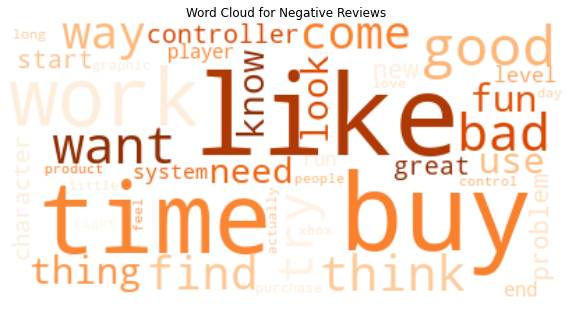

In [68]:
# Negative wordcloud
f, axes = plt.subplots(figsize=(10,7))
wordcloud.generate(negative_review_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title(f"Word Cloud for Negative Reviews")
plt.axis("off")
plt.show();

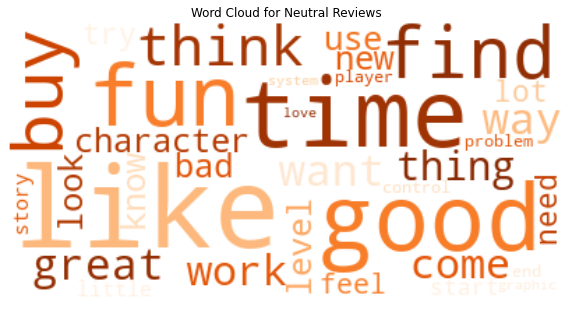

In [69]:
# Neutral wordcloud
f, axes = plt.subplots(figsize=(10,7))
wordcloud.generate(neutral_review_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title(f"Word Cloud for Neutral Reviews")
plt.axis("off")
plt.show();

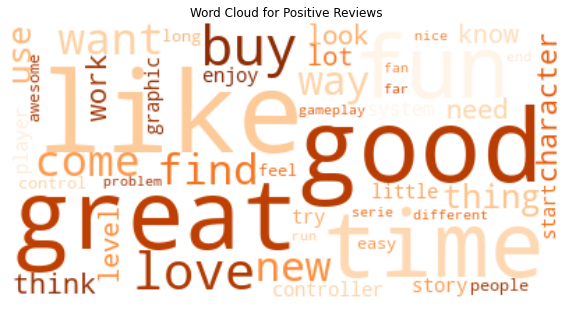

In [70]:
# Positive wordcloud
f, axes = plt.subplots(figsize=(10,7))
wordcloud.generate(positive_review_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title(f"Word Cloud for Positive Reviews")
plt.axis("off")
plt.show();

In [186]:
# See what happened if we add two more stopwords to spacy
# It is suggested in a research that it would be helpful to remove stopwords that are particular relevant to the product category
# So that we will be able to see what else is being talked about
STOP_WORDS.update({"game","play","thing","lot"})

In [187]:
# Define a function to remove "game", "play", "thing", and "lot"

def remove_sw(review):
    token_list = [word.text for word in review]
    tokens_without_sw = [word for word in token_list if word not in STOP_WORDS]
    return tokens_without_sw

# apply the function to every row in the 'tokens' column
sample_df3['clean_tokens_v2'] = sample_df3['afterlem_review'].apply(lambda x: remove_sw(nlp(x)))

In [188]:
sample_df3 = sample_df3.sort_values(by=['clean_tokens_v2'], ascending=True)

In [189]:
sample_df3.head(39)

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count,tokens,token_count,tokens_nosw,nosw_review,nosw_pure_review,afterlem_review,clean_tokens,clean_tokens_v2
340491,B001UWGBC8,Marvel Ultimate Alliance 2,1,Five Stars,this has gotten a lot of play.,2014-12-28,"[This, has, gotten, a, lot, of, play.]",7,"[this, has, gotten, a, lot, of, play, .]",8,"[gotten, lot, play, .]",gotten lot play .,gotten lot play,get lot play,"[get, lot, play]",[]
859068,B0050SZD18,OUYA Console and Controller,-1,OUYA Night Mare,"from 0 to 10 give them 5 the controller the nicest thing. firmware a crab , console design cool. games old school cheap stuff, emulators a plus, pain in the butt for rom's , needs time for product mature . shipping product a mess apparently delivered on the moon. feels like being fool with promises with nice advertisements.",2013-06-27,"[From, 0, to, 10, give, them, 5, the, controller, the, nicest, thing., Firmware, a, crab, ,, console, design, cool., games, old, school, cheap, stuff,, emulators, a, plus,, pain, in, the, butt, for, rom's, ,, needs, time, for, product, mature, ., Shipping, product, a, mess, apparently, delivered, on, the, moon., Feels, like, being, fool, with, promises, with, nice, advertisements.]",58,"[from, 0, to, 10, give, them, 5, the, controller, the, nicest, thing, ., firmware, a, crab, ,, console, design, cool, ., games, old, school, cheap, stuff, ,, emulators, a, plus, ,, pain, in, the, butt, for, rom, 's, ,, needs, time, for, product, mature, ., shipping, product, a, mess, apparently, delivered, on, the, moon, ., feels, like, being, fool, with, promises, with, nice, advertisements, .]",65,"[0, 10, 5, controller, nicest, thing, ., firmware, crab, ,, console, design, cool, ., games, old, school, cheap, stuff, ,, emulators, plus, ,, pain, butt, rom, ,, needs, time, product, mature, ., shipping, product, mess, apparently, delivered, moon, ., feels, like, fool, promises, nice, advertisements, .]","0 10 5 controller nicest thing . firmware crab , console design cool . games old school cheap stuff , emulators plus , pain butt rom , needs time product mature . shipping product mess apparently delivered moon . feels like fool promises nice advertisements .",0 10 5 controller nicest thing firmware crab console design cool games old school cheap stuff emulators plus pain butt rom needs time product mature shipping product mess apparently delivered moon feels like fool promises nice advertisements,0 10 5 controller nice thing firmware crab console design cool game old school cheap stuff emulator plus pain butt rom need time product mature shipping product mess apparently deliver moon feel like fool promise nice advertisement,"[0, 10, 5, controller, nice, thing, firmware, crab, console, design, cool, game, old, school, cheap, stuff, emulator, plus, pain, butt, rom, need, time, product, mature, shipping, product, mess, apparently, deliver, moon, feel, like, fool, promise, nice, advertisement]","[0, 10, 5, controller, nice, firmware, crab, console, design, cool, old, school, cheap, stuff, emulator, plus, pain, butt, rom, need, time, product, mature, shipping, product, mess, apparently, deliver, moon, feel, like, fool, promise, nice, advertisement]"
410408,B005IIR9NK,KMD 3DS Snap On BackUp Battery,0,it was $0. 22 so why not? Its ...,"it was $0.22 so why not? its okay, but feels too bulky and doesn's ;snap ; on.",2014-11-11,"[it, was, $0.22, so, why, not?, , Its, okay,, but, feels, too, bulky, and, doesn's, , ;snap, ;, on.]",19,"[it, was, $, 0.22, so, why, not, ?, , its, okay, ,, but, feels, too, bulky, and, doesn, 's, , ;, snap, ;, on, .]",25,"[$, 0.22, ?, , okay, ,, feels, bulky, doesn, , ;, snap, ;, .]","$ 0.22 ? okay , feels bulky doesn ; snap ; .",0 22 okay feels bulky doesn snap,0 22 okay feel bulky doesn snap,"[0, 22, okay, feel, bulky, doesn, snap]","[0, 22, okay, feel, bulky, doesn, snap]"
764617,B00DE2W5XG,PlayStation 4 Battlefield 4 Launch Day Bundle,-1,.4% Huh

In [78]:
sample_df3.drop(sample_df3.head(38).index, inplace = True)
sample_df3.star_rating.value_counts()

 0    15975
-1    15972
 1    15956
Name: star_rating, dtype: int64

In [191]:
# Resample to make it a balanced dataset

# Set sample size
sample_size = 15000
sample_df4 = pd.DataFrame()
for i in sample_df3.star_rating.unique():
    X = sample_df3[sample_df3.star_rating == i].sample(sample_size)
    sample_df4 = sample_df4.append(X)
sample_df4.star_rating.value_counts()

-1    15000
 0    15000
 1    15000
Name: star_rating, dtype: int64

In [192]:
# Join the tokens

def rejoin(token_list):
    return " ".join([token for token in token_list])

# Apply the function to every row in the column
sample_df4['final_review'] = sample_df4['clean_tokens_v2'].apply(lambda x: rejoin(x))
sample_df4

,product_id,product_title,star_rating,review_headline,review_body,review_date,splitted_words,word_count,tokens,token_count,tokens_nosw,nosw_review,nosw_pure_review,afterlem_review,clean_tokens,clean_tokens_v2,final_review
363561,B00CM2O5G4,E-MODS GAMING® Custom Xbox 360 Controller 9mm Metal ABXY/Guide buttons (Metal Silver),-1,. Special tool is needed to change buttons. ...,". special tool is needed to change buttons. it did not come with item, company did not respond to email request, lowes and game stop do not sell tool. buttons are worthless without tool.",2014-12-15,"[., Special, tool, is, needed, to, change, buttons., IT, did, not, come, with, item,, company, did, not, respond, to, email, request,, Lowes, and, game, stop, do, not, sell, tool., Buttons, are, worthless, without, tool.]",34,"[., special, tool, is, needed, to, change, buttons, ., it, did, not, come, with, item, ,, company, did, not, respond, to, email, request, ,, lowes, and, game, stop, do, not, sell, tool, ., buttons, are, worthless, without, tool, .]",39,"[., special, tool, needed, change, buttons, ., come, item, ,, company, respond, email, request, ,, lowes, game, stop, sell, tool, ., buttons, worthless, tool, .]",". special tool needed change buttons . come item , company respond email request , lowes game stop sell tool . buttons worthless tool .",special tool needed change buttons come item company respond email request lowes game stop sell tool buttons worthless tool,special tool need change button come item company respond email request lowes game stop sell tool button worthless tool,"[special, tool, need, change, button, come, item, company, respond, email, request, lowes, game, stop, sell, tool, button, worthless, tool]","[special, tool, need, change, button, come, item, company, respond, email, request, lowes, stop, sell, tool, button, worthless, tool]",special tool need change button come item company respond email request lowes stop sell tool button worthless tool
1255063,B003IU01TY,Afterglow AX.1 Controller for Xbox 360 - Green,-1,Fail on pelicain,ok. i have bought many pelicain type products (thats who made the controler) and i have always had an issue. its because they break. the controler after a year just would move down randomly. i couldnt fix it. it was good. thats about how long these product lasts. go pay the extra 20 for a microsoft controler. its worth it.,2011-03-16,"[OK., I, have, bought, many, pelicain, type, products, (thats, who, made, the, controler), and, i, have, always, had, an, issue., Its, because, they, break., The, controler, after, a, year, just, would, move, down, randomly., I, couldnt, fix, it., It, was, good., thats, about, how, long, these, product, lasts., go, pay, the, extra, 20, for, a, microsoft, controler., Its, worth, it.]",60,"[ok, ., i, have, bought, many, pelicain, type, products, (, that, s, who, made, the, controler, ), and, i, have, always, had, an, issue, ., its, because, they, break, ., the, controler, after, a, year, just, would, move, down, randomly, ., i, could, nt, fix, it, ., it, was, good, ., that, s, about, how, long, these, product, lasts, ., go, pay, the, extra, 20, for, a, microsoft, controler, ., its, worth, it, .]",74,"[ok, ., bought, pelicain, type, products, (, s, controler, ), issue, ., break, ., controler, year, randomly, ., nt, fix, ., good, ., s, long, product, lasts, ., pay, extra, 20, microsoft, controler, ., worth, .]",ok . bought pelicain type products ( s controler ) issue . break . controler year randomly . nt fix . good . s long product lasts . pay extra 20 microsoft controler . worth .,ok bought pelicain type products s controler issue break controler year randomly nt fix good s long product lasts pay extra 20 microsoft controler worth,ok buy pelicain type product s controler issue break controler year randomly not fix good s long product last pay extra 20 microsoft controler worth,"[ok, buy, pelicain, type, product, s, controler, issue, break, controler, year, randomly, not, f

In [199]:
# Initialisig wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords = STOP_WORDS, min_font_size=10, \
                      max_font_size=100, max_words=50, \
                      background_color="white", colormap = "Oranges")

negative_review_text = " ".join(sample_df4[sample_df4["star_rating"]==-1]["final_review"].values).lower()
neutral_review_text = " ".join(sample_df4[sample_df4["star_rating"]==0]["final_review"].values).lower()
positive_review_text = " ".join(sample_df4[sample_df4["star_rating"]==1]["final_review"].values).lower()

text_list = [negative_review_text, neutral_review_text, positive_review_text]

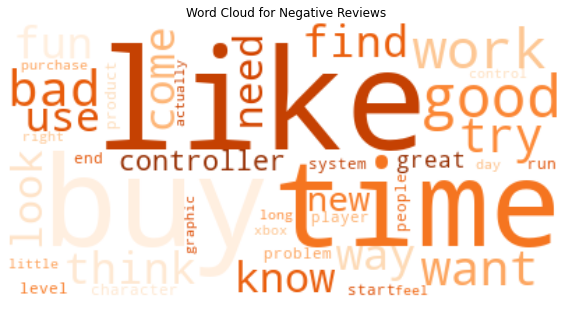

In [200]:
# Negative wordcloud

f, axes = plt.subplots(figsize=(10,7))
wordcloud.generate(negative_review_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title(f"Word Cloud for Negative Reviews")
plt.axis("off")
plt.savefig("wordcloud_neg.png",dpi=600,facecolor='w',edgecolor='w',bbox_inches='tight')
plt.show();

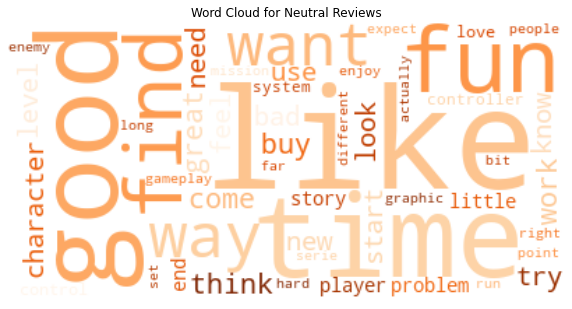

In [201]:
# Neutral wordcloud
f, axes = plt.subplots(figsize=(10,7))
wordcloud.generate(neutral_review_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title(f"Word Cloud for Neutral Reviews")
plt.axis("off")
plt.savefig("wordcloud_neu.png",dpi=600,facecolor='w',edgecolor='w',bbox_inches='tight')
plt.show();

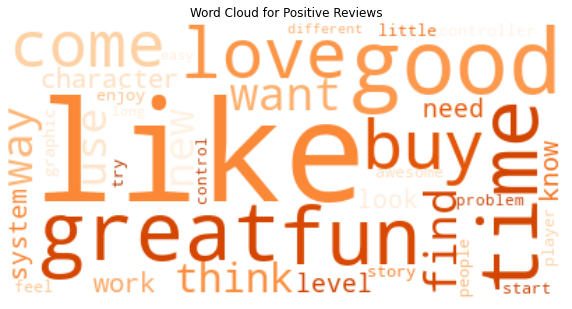

In [202]:
# Positive wordcloud
f, axes = plt.subplots(figsize=(10,7))
wordcloud.generate(positive_review_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title(f"Word Cloud for Positive Reviews")
plt.axis("off")
plt.savefig("wordcloud_pos.png",dpi=600,facecolor='w',edgecolor='w',bbox_inches='tight')
plt.show();

In [203]:
sample_df4.to_csv("cleaned_df15000.csv")

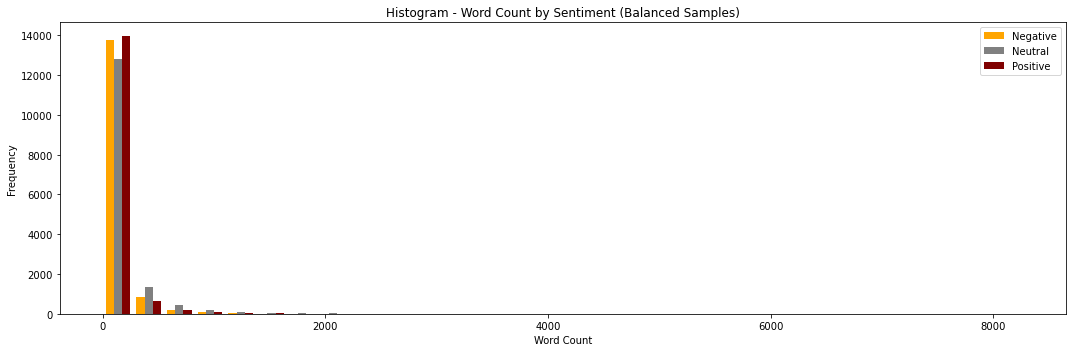

In [204]:
# Try to plot the histogram again to see if the same pattern happens again
# If yes, review length does have a general pattern by sentiment class

%matplotlib inline

fig, ax = plt.subplots(figsize=(15,5))

n_bins = 30

colors = ['orange', 'grey', 'maroon']

x_multi = [sample_df4[sample_df4['star_rating'] == -1]['word_count'],sample_df4[sample_df4['star_rating'] == 0]['word_count'],
          sample_df4[sample_df4['star_rating'] == 1]['word_count']]
ax.hist(x_multi, n_bins, histtype='bar', color=colors)
ax.set_title('Histogram - Word Count by Sentiment (Balanced Samples)')
ax.legend(['Negative', 'Neutral','Positive'])

plt.xlabel('Word Count')
plt.ylabel('Frequency')

fig.tight_layout()
plt.show();

After resampling, the word count length appears a similar pattern as before sampling.

In [87]:
sample_df4['ctokens_count'] = sample_df4['clean_tokens_v2'].apply(len)

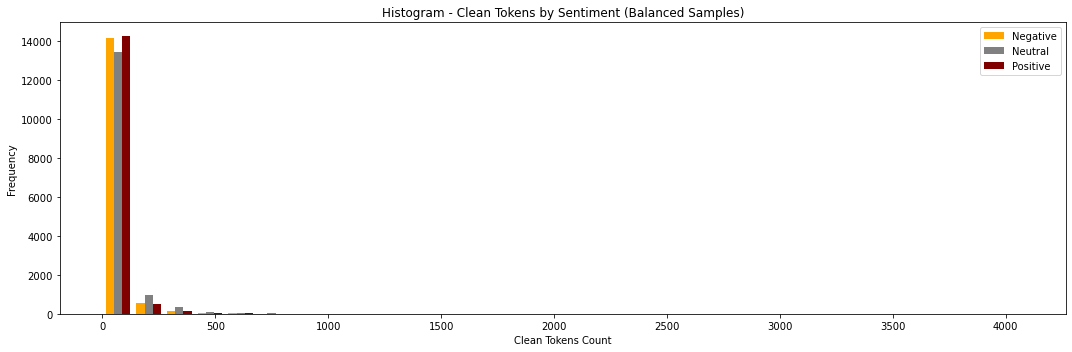

In [88]:
# Try to plot the histogram again to see if the same pattern happens again
# If yes, review length does have a general pattern by sentiment class

%matplotlib inline

fig, ax = plt.subplots(figsize=(15,5))

n_bins = 30

colors = ['orange', 'grey', 'maroon']

x_multi = [sample_df4[sample_df4['star_rating'] == -1]['ctokens_count'],sample_df4[sample_df4['star_rating'] == 0]['ctokens_count'],
          sample_df4[sample_df4['star_rating'] == 1]['ctokens_count']]
ax.hist(x_multi, n_bins, histtype='bar', color=colors)
ax.set_title('Histogram - Clean Tokens by Sentiment (Balanced Samples)')
ax.legend(['Negative', 'Neutral','Positive'])

plt.xlabel('Clean Tokens Count')
plt.ylabel('Frequency')

fig.tight_layout()
plt.show();

Pre-processing did not significantly affect the review length distribution.

## 4. Modeling

We tried to use the data cleaned from using SpaCy stopwords removal to build some machine learning models, but the accuracy scores were not satisfcatory compared to if we use the data cleaned from using NLTK stopwords removal. Hence, we will redo the data pre-procesing with NLTK packages for all the modeling tasks.

### 4.1 Prepare Train and Test Set

In [91]:
clean_data = sample_df4[['product_id','product_title','star_rating','review_headline','review_body','review_date','final_review','clean_tokens_v2']]

In [101]:
x = clean_data['final_review']
y = clean_data['star_rating']
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, stratify=y, random_state = 44)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=44) 
#0.25 x 0.8 = 0.2

In [112]:
clean_data.to_csv("clean_data_for_modeling.csv")

### 4.2 Multinomial Naive Bayes Classifier

In [102]:
# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vectorize', CountVectorizer(ngram_range=(1, 2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [103]:
nb.fit(X_train, y_train)

y_train_pred_nb = nb.predict(X_train)
y_val_pred_nb = nb.predict(X_val)

print(f"Training Set Accuracy: {accuracy_score(y_train, y_train_pred_nb)*100:.3f}%")
print(f"Validation Set Accuracy: {accuracy_score(y_val, y_val_pred_nb)*100:.3f}%")

print(f"Training Set F1 Score: {f1_score(y_train, y_train_pred_nb, average='micro'):.3f}")
print(f"Validation Set F1 Score: {f1_score(y_val, y_val_pred_nb, average='micro'):.3f}")

Training Set Accuracy: 90.737%
Validation Set Accuracy: 60.756%
Training Set F1 Score: 0.907
Validation Set F1 Score: 0.608


### 4.3 Stochastic Gradient Descent

In [104]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier()),
               ])

In [105]:
sgd.fit(X_train, y_train)

y_train_pred_sgd = sgd.predict(X_train)
y_val_pred_sgd = sgd.predict(X_val)

print(f"Training Set Accuracy: {accuracy_score(y_train, y_train_pred_sgd)*100:.3f}%")
print(f"Validation Set Accuracy: {accuracy_score(y_val, y_val_pred_sgd)*100:.3f}%")

print(f"Training Set F1 Score: {f1_score(y_train, y_train_pred_sgd, average='micro'):.3f}")
print(f"Validation Set F1 Score: {f1_score(y_val, y_val_pred_sgd, average='micro'):.3f}")

Training Set Accuracy: 88.033%
Validation Set Accuracy: 65.844%
Training Set F1 Score: 0.880
Validation Set F1 Score: 0.658


### 4.4 Random Forest

In [106]:
from sklearn.ensemble import RandomForestClassifier

rnd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(random_state=42, n_estimators=10)),
               ])

In [107]:
rnd.fit(X_train, y_train)

y_train_pred_rnd = rnd.predict(X_train)
y_val_pred_rnd = rnd.predict(X_val)

print(f"Training Set Accuracy: {accuracy_score(y_train, y_train_pred_rnd)*100:.3f}%")
print(f"Validation Set Accuracy: {accuracy_score(y_val, y_val_pred_rnd)*100:.3f}%")

print(f"Training Set F1 Score: {f1_score(y_train, y_train_pred_rnd, average='micro'):.3f}")
print(f"Validation Set F1 Score: {f1_score(y_val, y_val_pred_rnd, average='micro'):.3f}")

Training Set Accuracy: 98.107%
Validation Set Accuracy: 55.567%
Training Set F1 Score: 0.981
Validation Set F1 Score: 0.556


### 4.5 Logistic Regression

In [108]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=500)),
               ])

In [109]:
logreg.fit(X_train, y_train)

y_train_pred_log = logreg.predict(X_train)
y_val_pred_log = logreg.predict(X_val)


print(f"Training Set Accuracy: {accuracy_score(y_train, y_train_pred_log)*100:.3f}%")
print(f"Validation Set Accuracy: {accuracy_score(y_val, y_val_pred_log)*100:.3f}%")

print(f"Training Set F1 Score: {f1_score(y_train, y_train_pred_log, average='micro'):.3f}")
print(f"Validation Set F1 Score: {f1_score(y_val, y_val_pred_log, average='micro'):.3f}")

Training Set Accuracy: 91.881%
Validation Set Accuracy: 66.433%
Training Set F1 Score: 0.919
Validation Set F1 Score: 0.664


### 4.6 Linear Support Vector Classifier

In [110]:
from sklearn.svm import SVC

svc = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC()),
               ])

In [111]:
svc.fit(X_train, y_train)

y_train_pred_svc = svc.predict(X_train)
y_val_pred_svc = svc.predict(X_val)

print(f"Training Set Accuracy: {accuracy_score(y_train, y_train_pred_svc)*100:.3f}%")
print(f"Validation Set Accuracy: {accuracy_score(y_val, y_val_pred_svc)*100:.3f}%")

print(f"Training Set F1 Score: {f1_score(y_train, y_train_pred_svc, average='micro'):.3f}")
print(f"Validation Set F1 Score: {f1_score(y_val, y_val_pred_svc, average='micro'):.3f}")

Training Set Accuracy: 98.037%
Validation Set Accuracy: 66.167%
Training Set F1 Score: 0.980
Validation Set F1 Score: 0.662


### 4.7 Model Comparison

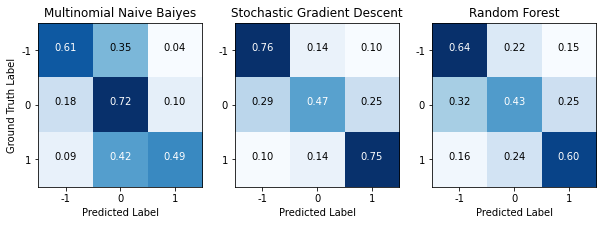

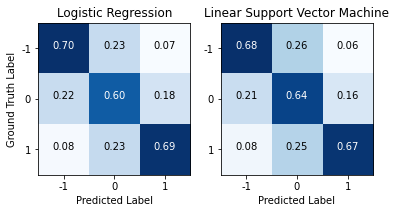

In [114]:
import itertools

def plot_confusion_matrix(cm, classes, ax, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues, set_y_label = True):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # Add the labels
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set(yticks=[0,1,2], 
            xticks=[0, 1, 2], 
           yticklabels=classes, 
           xticklabels=classes)
    #ax.yaxis.set_major_locator(matplotlib.ticker.IndexLocator(base=1, offset=0.5))
    if title:
        ax.set_title(title)
    if(set_y_label):
        ax.set_ylabel('Ground Truth Label')
    ax.set_xlabel('Predicted Label')
    
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 10))

plot_confusion_matrix(confusion_matrix(y_val, y_val_pred_nb), ("-1","0", "1"), 
                      ax[0], normalize=True, title = 'Multinomial Naive Baiyes')
plot_confusion_matrix(confusion_matrix(y_val, y_val_pred_sgd), ("-1","0", "1"), 
                      ax[1], normalize=True, title = 'Stochastic Gradient Descent',set_y_label = False)
plot_confusion_matrix(confusion_matrix(y_val, y_val_pred_rnd), ("-1","0", "1"), 
                      ax[2], normalize=True, title = 'Random Forest',set_y_label = False)


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(6, 10))

plot_confusion_matrix(confusion_matrix(y_val, y_val_pred_log), ("-1","0", "1"), 
                      ax[0], normalize=True, title = 'Logistic Regression')
plot_confusion_matrix(confusion_matrix(y_val, y_val_pred_svc), ("-1","0", "1"), 
                      ax[1], normalize=True, title = 'Linear Support Vector Machine',set_y_label = False)

### 4.8 Fine-Tuning Logistic Regression

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.or

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got el

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got el

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. Th

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=1, max_iter=500))])
0.6541481481481483
Training Set Accuracy: 91.881%
Validation Set Accuracy: 66.433%
Training Set F1 Score: 0.919
Validation Set F1 Score: 0.664


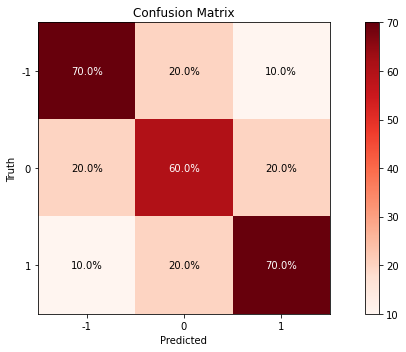

In [119]:
from sklearn.model_selection import GridSearchCV

grid=[{'clf__solver': ['lbfgs', 'sag', 'saga'],
       'clf__penalty': ['none', 'l1', 'l2', 'elasticnet'],
       'clf__C': [0.01, 0.1, 1]}]
lr = GridSearchCV(logreg, param_grid = grid, cv = 5, scoring='accuracy', verbose = 1, n_jobs = -1)
best_model = lr.fit(X_train, y_train)

print(best_model.best_estimator_)
print(best_model.best_score_)

y_train_pred_grid = best_model.predict(X_train)
y_val_pred_grid = best_model.predict(X_val)

print(f"Training Set Accuracy: {accuracy_score(y_train, y_train_pred_grid)*100:.3f}%")
print(f"Validation Set Accuracy: {accuracy_score(y_val, y_val_pred_grid)*100:.3f}%")

print(f"Training Set F1 Score: {f1_score(y_train, y_train_pred_grid, average='micro'):.3f}")
print(f"Validation Set F1 Score: {f1_score(y_val, y_val_pred_grid, average='micro'):.3f}")
plotConfusionMatrix(confusion_matrix(y_val, y_val_pred_grid))

Training Set Accuracy: 91.881%
Validation Set Accuracy: 66.078%
Training Set F1 Score: 0.919
Validation Set F1 Score: 0.661


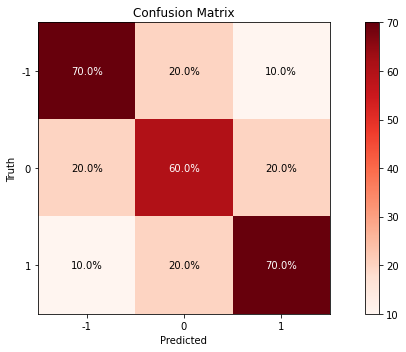

In [138]:
# Fit into Test Set

y_train_pred_grid = best_model.predict(X_train)
y_test_pred_grid = best_model.predict(X_test)

print(f"Training Set Accuracy: {accuracy_score(y_train, y_train_pred_grid)*100:.3f}%")
print(f"Validation Set Accuracy: {accuracy_score(y_test, y_test_pred_grid)*100:.3f}%")

print(f"Training Set F1 Score: {f1_score(y_train, y_train_pred_grid, average='micro'):.3f}")
print(f"Validation Set F1 Score: {f1_score(y_test, y_test_pred_grid, average='micro'):.3f}")
plotConfusionMatrix(confusion_matrix(y_test, y_test_pred_grid))

In [149]:
compare_X_test = pd.DataFrame(X_test)
compare_X_test['prediction'] = y_test_pred_grid
compare_X_test = compare_X_test.merge(clean_data['star_rating'], left_index=True, right_index=True, how='left')
compare_X_test['correct'] = None
for i in compare_X_test.index:
    if compare_X_test['prediction'][i] == compare_X_test['star_rating'][i]:
        compare_X_test['correct'][i] = 'True'
    else:
        compare_X_test['correct'][i] = 'False'
false_pred = compare_X_test[compare_X_test['correct']=='False']
false_pred

,final_review,prediction,star_rating,correct
266461,simply old classic old 90 era time resource management plant garden supply sunlight pay attack plant zombie horde overrun yard replace destroy plant obstacle stem tide available android google store blast original particular product come heavy weapon atomic tank peggle arcade classic start heavy weapon xbox live disappointed playstation network know available finally find way ps3 anymore peggle pretty fun short great youngun adult enjoy simple learn difficult reach high level atomic tank men...,0,1,False
1304837,buy connect nintendo ds lite internet official nintendo product discontinue available lot expensive product easy install easy work require minimal formatting step step instruction product website receive installation cd manual product find readily available download website free single download label pc041 wifi link psp ndsl case find difficult plug usb download file open save waste computer space open folder double click file set follow wizard worry window inform compatible cause problem kn...,-1,1,False
1752812,twist metal great nothin beat fully equip vehicle battle world hope victor claming ultimate prize desire battle way los angeles desroye path vehicle choose darkside sweet tooth yellow jacket outlaw pit viper definetly pick check twisted metal 2 em,1,-1,False
576676,quality seller like thought bad control old tomb raider,-1,0,False
43037,honestly shock people issue headset maybe stroke good luck fantastic use pc ps4 sell console work great term connectivity matter swap usb pc ps4 vice versa sound wise bass bit lack crisp sound good mic work easy use mute friend tell come clearly way build wear hour notice comfy break plastic stretching pliability open wide fit head issue notice plastic pro comfy great sound fit great ear good mic nice setting con bass overall price skullcandy good customer service,0,1,False
...,...,...,...,...
1309844,love thing wear stick smooth slightly misshapen finger slip heated battle kinda nice eat finger greasy stick grip pull finger away wipe grease food leave grip reuse controller spring finally spring new inferior analog stick ps3 alittle bearable fps woot,0,1,False
428535,kind wrestling boy lot fun add gamecube collection seller feedback day late glad condition flawless,1,0,False
71848,rubber controller come right couple day,0,-1,False
638685,stick awesome work wishbit jump shoot tho use sync button xbox s got lose,-1,1,False


In [148]:
compare_X_test

,final_review,prediction,star_rating
646791,great pc gaming ps4 tool let use controller pc thing awesome,1,1
266461,simply old classic old 90 era time resource management plant garden supply sunlight pay attack plant zombie horde overrun yard replace destroy plant obstacle stem tide available android google store blast original particular product come heavy weapon atomic tank peggle arcade classic start heavy weapon xbox live disappointed playstation network know available finally find way ps3 anymore peggle pretty fun short great youngun adult enjoy simple learn difficult reach high level atomic tank men...,0,1
1488715,fun exciting decide bring old classic problem thing point guess problem 7 anymore depth interest,0,0
501620,uh server shut january rear render completely useless,-1,-1
1304837,buy connect nintendo ds lite internet official nintendo product discontinue available lot expensive product easy install easy work require minimal formatting step step instruction product website receive installation cd manual product find readily available download website free single download label pc041 wifi link psp ndsl case find difficult plug usb download file open save waste computer space open folder double click file set follow wizard worry window inform compatible cause problem kn...,-1,1
...,...,...,...
638685,stick awesome work wishbit jump shoot tho use sync button xbox s got lose,-1,1
1452390,waste time try sorry waste time try review great premise good idea gameplay clumsy try face war instead,-1,-1
1634393,long time player asherson asheron 2 decide star war try heck fan admit far expect player want like dance local cantina healing wound medical center exchange blaster fire storm tropper ui fantastic sound graphic immpressive offer true sense immersion star war genere season mmorpg thing buyer expect need understand thing change funniest thing today old tommorrow soe lucas arts great job update monthly basis time mmorpg player season player star wars fan sure find fun 5 star great,1,1
347421,poor customer support poor dysfunctional credit card manager time complete purchase blue iris impossible software fair bug address software developer come close misrepresent package ability want shop blue iris way price comparison software competitor event camera developer promote think primarily successful overall guy look right blue iris money attempt listen support level fall death ear imagine stay way long free ride camera folk,-1,0


In [150]:
# Compare what words contributed to the sentiment identified by the machine
compare_X_train = pd.DataFrame(X_train)
compare_X_train['prediction'] = y_train_pred_grid
compare_X_train = compare_X_train.merge(clean_data['star_rating'], left_index=True, right_index=True, how='left')

In [151]:
# Initialisig wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords = STOP_WORDS, min_font_size=10, \
                      max_font_size=80, max_words=50, \
                      background_color="white", colormap = "Oranges")

negative_review_text = " ".join(compare_X_train[compare_X_train["prediction"]==-1]["final_review"].values).lower()
neutral_review_text = " ".join(compare_X_train[compare_X_train["prediction"]==0]["final_review"].values).lower()
positive_review_text = " ".join(compare_X_train[compare_X_train["prediction"]==1]["final_review"].values).lower()

text_list = [negative_review_text, neutral_review_text, positive_review_text]

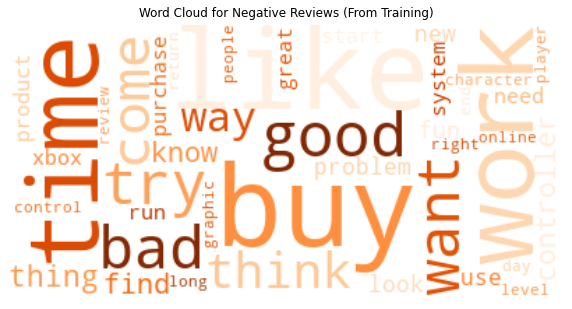

In [152]:
# Negative wordcloud

f, axes = plt.subplots(figsize=(10,7))
wordcloud.generate(negative_review_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title(f"Word Cloud for Negative Reviews (From Training)")
plt.axis("off")
plt.savefig("wordcloud_neg_pred.png",dpi=600,facecolor='w',edgecolor='w',bbox_inches='tight')
plt.show();

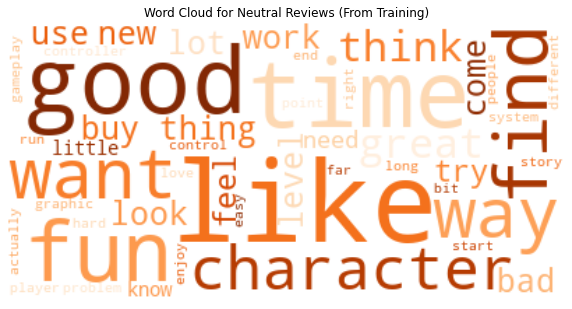

In [153]:
# Neutral wordcloud
f, axes = plt.subplots(figsize=(10,7))
wordcloud.generate(neutral_review_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title(f"Word Cloud for Neutral Reviews (From Training)")
plt.axis("off")
plt.savefig("wordcloud_neu_pred.png",dpi=600,facecolor='w',edgecolor='w',bbox_inches='tight')
plt.show();

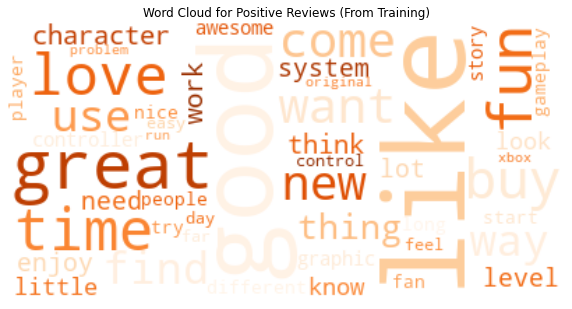

In [154]:
# Positive wordcloud
f, axes = plt.subplots(figsize=(10,7))
wordcloud.generate(positive_review_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title(f"Word Cloud for Positive Reviews (From Training)")
plt.axis("off")
plt.savefig("wordcloud_pos_pred.png",dpi=600,facecolor='w',edgecolor='w',bbox_inches='tight')
plt.show();

### Correlation Matrix

In [120]:
clean_data

,product_id,product_title,star_rating,review_headline,review_body,review_date,final_review,clean_tokens_v2
850982,B00AAOMJMS,UTR? DualShock 3 Wireless Controller for PS3 Playstation 3 - Black [Retail Packaging],-1,just OK,"controls are very temperamental with the ps3. doesn't work wirelessly at all, and even plugged in sometimes i have to mess with it/reboot just to get it to netflix... disappointing.",2013-07-10,control temperamental ps3 work wirelessly plug mess reboot netflix disappoint,"[control, temperamental, ps3, work, wirelessly, plug, mess, reboot, netflix, disappoint]"
1019568,B003ZSP0WW,Microsoft Xbox360 Wireless Controller Microsoft,-1,does not sync to ebox,this will not sync to our x box. horrible that i have to return it and that it does not work out of the box.,2012-12-29,sync x box horrible return work box,"[sync, x, box, horrible, return, work, box]"
1444431,B001DDBBSS,Jillian Michael's Fitness Ultamatum 2009 - Nintendo Wii,-1,Boring!,"i was looking for a game that stacked up the exercises so that you didn't have to constantly hit \\""a\\"" like in wii fit. this does that, but you might as well run on the treadmill while watching rachel ray! this wii game gives disappointing response to your actions. most of the workout is spent running in a tree lined path (a frequently repeated pattern of rocks and bird feeders) watching your character from above/behind. swinging your arms really big makes you run, and sweat, but it is ...",2008-12-29,look stack exercise constantly hit like wii fit run treadmill watch rachel ray wii disappointing response action workout spend run tree line path frequently repeat pattern rock bird feeder watch character swinge arm big makes run sweat boring use balance board sway raising heel jump confused swinge bag obstacle path step balance board response character got knock foot single time indicator balance board respond correct reaction hang bag suppose punch punch punch high elbow swinge completely ...,"[look, stack, exercise, constantly, hit, like, wii, fit, run, treadmill, watch, rachel, ray, wii, disappointing, response, action, workout, spend, run, tree, line, path, frequently, repeat, pattern, rock, bird, feeder, watch, character, swinge, arm, big, makes, run, sweat, boring, use, balance, board, sway, raising, heel, jump, confused, swinge, bag, obstacle, path, step, balance, board, response, character, got, knock, foot, single, time, indicator, balance, board, respond, correct, reactio..."
1677684,B00006GSO0,Sims,-1,This Game is STUPID!,im friends wit a ea ceo and i pre tested the game and it was so stupid just to enter ur house it takes like 5 minutes do not get this game it is just a big waste of mulah (money)belive me i have all the sims expansion packs and this one is sllower than 1 on the slowest computer/ mac. this game is for pooples you cant do anything u could in any of the expansions. so just dont get this game! i no i put this game as a 1 star but it is not it would not let me put 0 stars. ...,2002-11-28,m friend wit ea ceo pre test stupid enter ur house like 5 minute big waste mulah money belive sim expansion pack sllower 1 slow computer mac poople nt u expansion 1 star let 0 star awsome video gamer u like,"[m, friend, wit, ea, ceo, pre, test, stupid, enter, ur, house, like, 5, minute, big, waste, mulah, money, belive, sim, expansion, pack, sllower, 1, slow, computer, mac, poople, nt, u, expansion, 1, star, let, 0, star, awsome, video, gamer, u, like]"
36229,B00FQDEKM0,Retro-Bit Super RetroTRIO Console NES/SNES/Genesis 3-In-1 System - Red/Black,-1,One Star,cheap poorly made didnt even work,2015-07-30,cheap poorly work,"[cheap, poorly, work]"
...,...,...,...,...,...,...,...,...
660458,B00C7103DO,Batman Arkham Origins,1,"Don't hesitate, just buy it!!","this games is the best in the series, in my opinion. it has a lot more gameplay options, which makes it less of a sandbox game after you beat the main story. i also recommend the season pass, in addition. the skins are rea

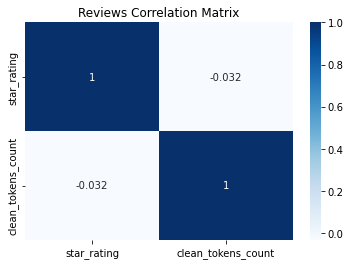

In [205]:
clean_data['clean_tokens_count'] = clean_data['clean_tokens_v2'].apply(len)

# Create heatmap
corr = clean_data[['star_rating','clean_tokens_count']].corr()
sns.heatmap(corr, cmap=plt.cm.Blues, annot=True)
plt.title('Reviews Correlation Matrix')
plt.show();

## 5. Verify Concepts from Sara and Norah (2019)

In [166]:
temp = clean_data.sort_values(by=['star_rating'], ascending=True)
neg_acc = temp[(temp['star_rating']==-1) & ((temp['final_review'].str.contains('controller')) |
                                                    (temp['final_review'].str.contains('system'))| 
                                                    (temp['final_review'].str.contains('control')) |
                                                    (temp['final_review'].str.contains('xbox')))]
neg_acc[['star_rating','review_body']].head(20)

,star_rating,review_body
850982,-1,"controls are very temperamental with the ps3. doesn't work wirelessly at all, and even plugged in sometimes i have to mess with it/reboot just to get it to netflix... disappointing."
824222,-1,"**contains spoilers ** ok, take every activity that you saved until the end of the main story from saints row 1-3 and glue them together with string and bailing wire, and you have the story for saint's row iv. after the rather fun intro (walk to the press room, kill the aliens attacking the white house, push through some of the lame activities - or as sr4 calls it - story, escape the vr, escape the mother ship, something happens, then walla back into the vr again for what appears to be the ..."
1319448,-1,"this product is not what it seems. after purchasing, i did some research and found out that these are xbox live silver accounts that these people take and load up points on them using stolen credit cards. that is why these are only guaranteed to work 5 days... buyer beware as you can be prosecuted as well!!! i stopped using mine and contacted microsoft about this issue. edit: after doing the research and finding our where these guys are getting these cards, i am going to share this with..."
731358,-1,"while the graphics are great for games over the xbox 360, as expected since it is a big upgrade in terms of graphics technology, the xbox one disappoints in its integration of media across the house. - while the xbox 360 supported the media center to play recorded tv, music, videos, and photos from a pc, the xbox one lacks this support (thus my wife banned it from the living room). - also lacking is dlna support to play media from other pcs or to send media to the xbox. it is advertised a..."
1511787,-1,"do not purchase this software. it is filled with game-crashing, system-stopping bugs. i have a great, fully updated system and it still crashes all the time. if you don't believe me, do a google search of \\""hellgate london bugs\\""...you'll find plenty to read. save your money and time! run!"
1293565,-1,"let me begin by saying that i'm reviewing as someone with a long history of experience driveng a wide variety of cars at race speeds both on and off pavement. i would expect a steering wheel to be a relatively easy thing to simulate. so, the big issue... the force feedback, primarily with gt5, is absolutely ridiculous to the point of being curse-worthy. constantly, with no rationale, there is a little jackhammer going off inside the wheel that blasts it in a random direction at a rando..."
1474435,-1,"i rented this from gamefly.com before even thinking about buying it, and am i glad i did. i played the original alone in the dark on a pc in the early 90's. it was a classic - scary, challenging without being frustrating and good game play. even though the graphics are without question better in this 2008 edition, the scare factor is gone. possessed persons and creatures in the game (in the game so far, as i haven't finished it yet and probably won't) are not frightening, mood music is not w..."
1715964,-1,"this is no good to the latest playstation2. if you have just got a playstation2 the ps2 gameshark disk won't work. you will have to also get the upgrade disk ... . you do need the gameshark \\""memory card\\"" thing to make the upgrade disk work. stuck between a rock and a hard place. well worth it other than you feel like you have been ripped off when you get it home and it doesn't work. then you can make it work if you are willing to spend just a little more money. the reason is the sony cha..."
1496290,-1,"this game to me is like live from last year... it sucks.... i played this using cfw but played only 1 quarter before i quit playing. i dont know why the other guy gave a 5 star review, because this game is horrific.. its exactly like live from last year, which i regrettable bought and played for about 10 games before i bought nba 07 from sony. that game played much better than live and i assume 

In [167]:
len(neg_acc)/len(temp[temp['star_rating']==-1])*100

26.0

In [169]:
pos_acc = temp[(temp['star_rating']==1) & ((temp['final_review'].str.contains('controller')) |
                                                    (temp['final_review'].str.contains('system'))| 
                                                    (temp['final_review'].str.contains('control')) |
                                                    (temp['final_review'].str.contains('xbox')))]
len(pos_acc)/len(temp[temp['star_rating']==1])*100

19.573333333333334

In [170]:
neu_acc = temp[(temp['star_rating']==0) & ((temp['final_review'].str.contains('controller')) |
                                                    (temp['final_review'].str.contains('system'))| 
                                                    (temp['final_review'].str.contains('control')) |
                                                    (temp['final_review'].str.contains('xbox')))]
len(neu_acc)/len(temp[temp['star_rating']==0])*100

27.013333333333335

#### Accessories

In [226]:
# include all words in the study

# negative - accessories
temp = clean_data.sort_values(by=['star_rating'], ascending=True)
neg_acc = temp[(temp['star_rating']==-1) & ((temp['final_review'].str.contains('controller')) |
                                            (temp['final_review'].str.contains('system'))| 
                                            (temp['final_review'].str.contains('control')) |
                                            (temp['final_review'].str.contains('xbox')) |
                                            (temp['final_review'].str.contains('button')) |
                                            (temp['final_review'].str.contains('console')) |
                                            (temp['final_review'].str.contains('feature')) |
                                            (temp['final_review'].str.contains('screen')) |
                                            (temp['final_review'].str.contains('headset')) |
                                            (temp['final_review'].str.contains('quality')) |
                                            (temp['final_review'].str.contains('sound')) |
                                            (temp['final_review'].str.contains('price')) |
                                            (temp['final_review'].str.contains('hand')) |
                                            (temp['final_review'].str.contains('launch')) |
                                            (temp['final_review'].str.contains('battery')) |
                                            (temp['final_review'].str.contains('mouse')) |
                                            (temp['final_review'].str.contains('card')) |
                                            (temp['final_review'].str.contains('box')) |
                                            (temp['final_review'].str.contains('cable')) |
                                            (temp['final_review'].str.contains('product')))]

neg_acc_per = len(neg_acc)/len(temp[temp['star_rating']==-1])*100

In [227]:
# neutral - accessories
neu_acc = temp[(temp['star_rating']==0) & ((temp['final_review'].str.contains('controller')) |
                                            (temp['final_review'].str.contains('system'))| 
                                            (temp['final_review'].str.contains('control')) |
                                            (temp['final_review'].str.contains('xbox')) |
                                            (temp['final_review'].str.contains('button')) |
                                            (temp['final_review'].str.contains('console')) |
                                            (temp['final_review'].str.contains('feature')) |
                                            (temp['final_review'].str.contains('screen')) |
                                            (temp['final_review'].str.contains('headset')) |
                                            (temp['final_review'].str.contains('quality')) |
                                            (temp['final_review'].str.contains('sound')) |
                                            (temp['final_review'].str.contains('price')) |
                                            (temp['final_review'].str.contains('hand')) |
                                            (temp['final_review'].str.contains('launch')) |
                                            (temp['final_review'].str.contains('battery')) |
                                            (temp['final_review'].str.contains('mouse')) |
                                            (temp['final_review'].str.contains('card')) |
                                            (temp['final_review'].str.contains('box')) |
                                            (temp['final_review'].str.contains('cable')) |
                                            (temp['final_review'].str.contains('product')))]

neu_acc_per = len(neu_acc)/len(temp[temp['star_rating']==0])*100

In [228]:
# positive - accessories
pos_acc = temp[(temp['star_rating']==1) & ((temp['final_review'].str.contains('controller')) |
                                            (temp['final_review'].str.contains('system'))| 
                                            (temp['final_review'].str.contains('control')) |
                                            (temp['final_review'].str.contains('xbox')) |
                                            (temp['final_review'].str.contains('button')) |
                                            (temp['final_review'].str.contains('console')) |
                                            (temp['final_review'].str.contains('feature')) |
                                            (temp['final_review'].str.contains('screen')) |
                                            (temp['final_review'].str.contains('headset')) |
                                            (temp['final_review'].str.contains('quality')) |
                                            (temp['final_review'].str.contains('sound')) |
                                            (temp['final_review'].str.contains('price')) |
                                            (temp['final_review'].str.contains('hand')) |
                                            (temp['final_review'].str.contains('launch')) |
                                            (temp['final_review'].str.contains('battery')) |
                                            (temp['final_review'].str.contains('mouse')) |
                                            (temp['final_review'].str.contains('card')) |
                                            (temp['final_review'].str.contains('box')) |
                                            (temp['final_review'].str.contains('cable')) |
                                            (temp['final_review'].str.contains('product')))]

pos_acc_per = len(pos_acc)/len(temp[temp['star_rating']==1])*100

#### Achievement

In [229]:
# include all words in the study

# negative - achievement
temp = clean_data.sort_values(by=['star_rating'], ascending=True)
neg_ach = temp[(temp['star_rating']==-1) & ((temp['final_review'].str.contains('enemy')) |
                                            (temp['final_review'].str.contains('character'))| 
                                            (temp['final_review'].str.contains('attack')) |
                                            (temp['final_review'].str.contains('battle')) |
                                            (temp['final_review'].str.contains('weapon')) |
                                            (temp['final_review'].str.contains('combat')) |
                                            (temp['final_review'].str.contains('ability')) |
                                            (temp['final_review'].str.contains('system')) |
                                            (temp['final_review'].str.contains('story')) |
                                            (temp['final_review'].str.contains('rpg')) |
                                            (temp['final_review'].str.contains('effect')) |
                                            (temp['final_review'].str.contains('skill')) |
                                            (temp['final_review'].str.contains('boss')) |
                                            (temp['final_review'].str.contains('quest')) |
                                            (temp['final_review'].str.contains('part')) |
                                            (temp['final_review'].str.contains('type')) |
                                            (temp['final_review'].str.contains('area')) |
                                            (temp['final_review'].str.contains('point')) |
                                            (temp['final_review'].str.contains('bit')) |
                                            (temp['final_review'].str.contains('pokemon')))]

neg_ach_per = len(neg_ach)/len(temp[temp['star_rating']==-1])*100

In [230]:
# neutral - achievement
neu_ach = temp[(temp['star_rating']==0) & ((temp['final_review'].str.contains('enemy')) |
                                            (temp['final_review'].str.contains('character'))| 
                                            (temp['final_review'].str.contains('attack')) |
                                            (temp['final_review'].str.contains('battle')) |
                                            (temp['final_review'].str.contains('weapon')) |
                                            (temp['final_review'].str.contains('combat')) |
                                            (temp['final_review'].str.contains('ability')) |
                                            (temp['final_review'].str.contains('system')) |
                                            (temp['final_review'].str.contains('story')) |
                                            (temp['final_review'].str.contains('rpg')) |
                                            (temp['final_review'].str.contains('effect')) |
                                            (temp['final_review'].str.contains('skill')) |
                                            (temp['final_review'].str.contains('boss')) |
                                            (temp['final_review'].str.contains('quest')) |
                                            (temp['final_review'].str.contains('part')) |
                                            (temp['final_review'].str.contains('type')) |
                                            (temp['final_review'].str.contains('area')) |
                                            (temp['final_review'].str.contains('point')) |
                                            (temp['final_review'].str.contains('bit')) |
                                            (temp['final_review'].str.contains('pokemon')))]

neu_ach_per = len(neu_ach)/len(temp[temp['star_rating']==0])*100

In [231]:
# positive - achievement
pos_ach = temp[(temp['star_rating']==1) & ((temp['final_review'].str.contains('enemy')) |
                                            (temp['final_review'].str.contains('character'))| 
                                            (temp['final_review'].str.contains('attack')) |
                                            (temp['final_review'].str.contains('battle')) |
                                            (temp['final_review'].str.contains('weapon')) |
                                            (temp['final_review'].str.contains('combat')) |
                                            (temp['final_review'].str.contains('ability')) |
                                            (temp['final_review'].str.contains('system')) |
                                            (temp['final_review'].str.contains('story')) |
                                            (temp['final_review'].str.contains('rpg')) |
                                            (temp['final_review'].str.contains('effect')) |
                                            (temp['final_review'].str.contains('skill')) |
                                            (temp['final_review'].str.contains('boss')) |
                                            (temp['final_review'].str.contains('quest')) |
                                            (temp['final_review'].str.contains('part')) |
                                            (temp['final_review'].str.contains('type')) |
                                            (temp['final_review'].str.contains('area')) |
                                            (temp['final_review'].str.contains('point')) |
                                            (temp['final_review'].str.contains('bit')) |
                                            (temp['final_review'].str.contains('pokemon')))]

pos_ach_per = len(pos_ach)/len(temp[temp['star_rating']==1])*100

#### Narrative

In [232]:
# include all words in the study

# negative - narrative
temp = clean_data.sort_values(by=['star_rating'], ascending=True)
neg_nar = temp[(temp['star_rating']==-1) & ((temp['final_review'].str.contains('story')) |
                                            (temp['final_review'].str.contains('character'))| 
                                            (temp['final_review'].str.contains('mission')) |
                                            (temp['final_review'].str.contains('gameplay')) |
                                            (temp['final_review'].str.contains('car')) |
                                            (temp['final_review'].str.contains('side')) |
                                            (temp['final_review'].str.contains('world')) |
                                            (temp['final_review'].str.contains('series')) |
                                            (temp['final_review'].str.contains('city')) |
                                            (temp['final_review'].str.contains('voice')) |
                                            (temp['final_review'].str.contains('money')) |
                                            (temp['final_review'].str.contains('choice')) |
                                            (temp['final_review'].str.contains('part')) |
                                            (temp['final_review'].str.contains('scene')) |
                                            (temp['final_review'].str.contains('storyline')) |
                                            (temp['final_review'].str.contains('detail')) |
                                            (temp['final_review'].str.contains('plot')) |
                                            (temp['final_review'].str.contains('guy')) |
                                            (temp['final_review'].str.contains('event')) |
                                            (temp['final_review'].str.contains('bit')))]

neg_nar_per = len(neg_nar)/len(temp[temp['star_rating']==-1])*100

In [233]:
# neutral - narrative
neu_nar = temp[(temp['star_rating']==0) & ((temp['final_review'].str.contains('story')) |
                                            (temp['final_review'].str.contains('character'))| 
                                            (temp['final_review'].str.contains('mission')) |
                                            (temp['final_review'].str.contains('gameplay')) |
                                            (temp['final_review'].str.contains('car')) |
                                            (temp['final_review'].str.contains('side')) |
                                            (temp['final_review'].str.contains('world')) |
                                            (temp['final_review'].str.contains('series')) |
                                            (temp['final_review'].str.contains('city')) |
                                            (temp['final_review'].str.contains('voice')) |
                                            (temp['final_review'].str.contains('money')) |
                                            (temp['final_review'].str.contains('choice')) |
                                            (temp['final_review'].str.contains('part')) |
                                            (temp['final_review'].str.contains('scene')) |
                                            (temp['final_review'].str.contains('storyline')) |
                                            (temp['final_review'].str.contains('detail')) |
                                            (temp['final_review'].str.contains('plot')) |
                                            (temp['final_review'].str.contains('guy')) |
                                            (temp['final_review'].str.contains('event')) |
                                            (temp['final_review'].str.contains('bit')))]

neu_nar_per = len(neu_nar)/len(temp[temp['star_rating']==0])*100

In [234]:
# positive - narrative
pos_nar = temp[(temp['star_rating']==1) & ((temp['final_review'].str.contains('story')) |
                                            (temp['final_review'].str.contains('character'))| 
                                            (temp['final_review'].str.contains('mission')) |
                                            (temp['final_review'].str.contains('gameplay')) |
                                            (temp['final_review'].str.contains('car')) |
                                            (temp['final_review'].str.contains('side')) |
                                            (temp['final_review'].str.contains('world')) |
                                            (temp['final_review'].str.contains('series')) |
                                            (temp['final_review'].str.contains('city')) |
                                            (temp['final_review'].str.contains('voice')) |
                                            (temp['final_review'].str.contains('money')) |
                                            (temp['final_review'].str.contains('choice')) |
                                            (temp['final_review'].str.contains('part')) |
                                            (temp['final_review'].str.contains('scene')) |
                                            (temp['final_review'].str.contains('storyline')) |
                                            (temp['final_review'].str.contains('detail')) |
                                            (temp['final_review'].str.contains('plot')) |
                                            (temp['final_review'].str.contains('guy')) |
                                            (temp['final_review'].str.contains('event')) |
                                            (temp['final_review'].str.contains('bit')))]

pos_nar_per = len(pos_nar)/len(temp[temp['star_rating']==1])*100

#### General Experience

In [235]:
# include all words in the study

# negative - general experience
temp = clean_data.sort_values(by=['star_rating'], ascending=True)
neg_ge = temp[(temp['star_rating']==-1) & ((temp['final_review'].str.contains('level')) |
                                            (temp['final_review'].str.contains('world'))| 
                                            (temp['final_review'].str.contains('music')) |
                                            (temp['final_review'].str.contains('item')) |
                                            (temp['final_review'].str.contains('challenge')) |
                                            (temp['final_review'].str.contains('soul')) |
                                            (temp['final_review'].str.contains('way')) |
                                            (temp['final_review'].str.contains('playe')) |
                                            (temp['final_review'].str.contains('design')) |
                                            (temp['final_review'].str.contains('fun')) |
                                            (temp['final_review'].str.contains('gameplay')) |
                                            (temp['final_review'].str.contains('puzzle')) |
                                            (temp['final_review'].str.contains('area')) |
                                            (temp['final_review'].str.contains('experience')) |
                                            (temp['final_review'].str.contains('idea')) |
                                            (temp['final_review'].str.contains('course')) |
                                            (temp['final_review'].str.contains('adventure')) |
                                            (temp['final_review'].str.contains('boss')) |
                                            (temp['final_review'].str.contains('series')) |
                                            (temp['final_review'].str.contains('difficulty')))]

neg_ge_per = len(neg_ge)/len(temp[temp['star_rating']==-1])*100

In [236]:
# neutral - general experience
neu_ge = temp[(temp['star_rating']==0) & ((temp['final_review'].str.contains('level')) |
                                            (temp['final_review'].str.contains('world'))| 
                                            (temp['final_review'].str.contains('music')) |
                                            (temp['final_review'].str.contains('item')) |
                                            (temp['final_review'].str.contains('challenge')) |
                                            (temp['final_review'].str.contains('soul')) |
                                            (temp['final_review'].str.contains('way')) |
                                            (temp['final_review'].str.contains('playe')) |
                                            (temp['final_review'].str.contains('design')) |
                                            (temp['final_review'].str.contains('fun')) |
                                            (temp['final_review'].str.contains('gameplay')) |
                                            (temp['final_review'].str.contains('puzzle')) |
                                            (temp['final_review'].str.contains('area')) |
                                            (temp['final_review'].str.contains('experience')) |
                                            (temp['final_review'].str.contains('idea')) |
                                            (temp['final_review'].str.contains('course')) |
                                            (temp['final_review'].str.contains('adventure')) |
                                            (temp['final_review'].str.contains('boss')) |
                                            (temp['final_review'].str.contains('series')) |
                                            (temp['final_review'].str.contains('difficulty')))]

neu_ge_per = len(neu_ge)/len(temp[temp['star_rating']==0])*100

In [237]:
# positive - general experience
pos_ge = temp[(temp['star_rating']==1) & ((temp['final_review'].str.contains('level')) |
                                            (temp['final_review'].str.contains('world'))| 
                                            (temp['final_review'].str.contains('music')) |
                                            (temp['final_review'].str.contains('item')) |
                                            (temp['final_review'].str.contains('challenge')) |
                                            (temp['final_review'].str.contains('soul')) |
                                            (temp['final_review'].str.contains('way')) |
                                            (temp['final_review'].str.contains('playe')) |
                                            (temp['final_review'].str.contains('design')) |
                                            (temp['final_review'].str.contains('fun')) |
                                            (temp['final_review'].str.contains('gameplay')) |
                                            (temp['final_review'].str.contains('puzzle')) |
                                            (temp['final_review'].str.contains('area')) |
                                            (temp['final_review'].str.contains('experience')) |
                                            (temp['final_review'].str.contains('idea')) |
                                            (temp['final_review'].str.contains('course')) |
                                            (temp['final_review'].str.contains('adventure')) |
                                            (temp['final_review'].str.contains('boss')) |
                                            (temp['final_review'].str.contains('series')) |
                                            (temp['final_review'].str.contains('difficulty')))]

pos_ge_per = len(pos_ge)/len(temp[temp['star_rating']==1])*100

#### Social Interaction

In [238]:
# include all words in the study

# negative - social interaction
temp = clean_data.sort_values(by=['star_rating'], ascending=True)
neg_si = temp[(temp['star_rating']==-1) & ((temp['final_review'].str.contains('player')) |
                                            (temp['final_review'].str.contains('mode'))| 
                                            (temp['final_review'].str.contains('fun')) |
                                            (temp['final_review'].str.contains('play')) |
                                            (temp['final_review'].str.contains('map')) |
                                            (temp['final_review'].str.contains('campaign')) |
                                            (temp['final_review'].str.contains('multiplayer')) |
                                            (temp['final_review'].str.contains('gun')) |
                                            (temp['final_review'].str.contains('online')) |
                                            (temp['final_review'].str.contains('shooter')) |
                                            (temp['final_review'].str.contains('weapon')) |
                                            (temp['final_review'].str.contains('person')) |
                                            (temp['final_review'].str.contains('call')) |
                                            (temp['final_review'].str.contains('ghost')) |
                                            (temp['final_review'].str.contains('point')) |
                                            (temp['final_review'].str.contains('team')) |
                                            (temp['final_review'].str.contains('zombie')) |
                                            (temp['final_review'].str.contains('battlefield')) |
                                            (temp['final_review'].str.contains('series')) |
                                            (temp['final_review'].str.contains('duty')))]

neg_si_per = len(neg_si)/len(temp[temp['star_rating']==-1])*100

In [239]:
# neutral - social interaction
neu_si = temp[(temp['star_rating']==0) & ((temp['final_review'].str.contains('player')) |
                                            (temp['final_review'].str.contains('mode'))| 
                                            (temp['final_review'].str.contains('fun')) |
                                            (temp['final_review'].str.contains('play')) |
                                            (temp['final_review'].str.contains('map')) |
                                            (temp['final_review'].str.contains('campaign')) |
                                            (temp['final_review'].str.contains('multiplayer')) |
                                            (temp['final_review'].str.contains('gun')) |
                                            (temp['final_review'].str.contains('online')) |
                                            (temp['final_review'].str.contains('shooter')) |
                                            (temp['final_review'].str.contains('weapon')) |
                                            (temp['final_review'].str.contains('person')) |
                                            (temp['final_review'].str.contains('call')) |
                                            (temp['final_review'].str.contains('ghost')) |
                                            (temp['final_review'].str.contains('point')) |
                                            (temp['final_review'].str.contains('team')) |
                                            (temp['final_review'].str.contains('zombie')) |
                                            (temp['final_review'].str.contains('battlefield')) |
                                            (temp['final_review'].str.contains('series')) |
                                            (temp['final_review'].str.contains('duty')))]

neu_si_per = len(neu_si)/len(temp[temp['star_rating']==0])*100

In [240]:
# positive - social interaction
pos_si = temp[(temp['star_rating']==1) & ((temp['final_review'].str.contains('player')) |
                                            (temp['final_review'].str.contains('mode'))| 
                                            (temp['final_review'].str.contains('fun')) |
                                            (temp['final_review'].str.contains('play')) |
                                            (temp['final_review'].str.contains('map')) |
                                            (temp['final_review'].str.contains('campaign')) |
                                            (temp['final_review'].str.contains('multiplayer')) |
                                            (temp['final_review'].str.contains('gun')) |
                                            (temp['final_review'].str.contains('online')) |
                                            (temp['final_review'].str.contains('shooter')) |
                                            (temp['final_review'].str.contains('weapon')) |
                                            (temp['final_review'].str.contains('person')) |
                                            (temp['final_review'].str.contains('call')) |
                                            (temp['final_review'].str.contains('ghost')) |
                                            (temp['final_review'].str.contains('point')) |
                                            (temp['final_review'].str.contains('team')) |
                                            (temp['final_review'].str.contains('zombie')) |
                                            (temp['final_review'].str.contains('battlefield')) |
                                            (temp['final_review'].str.contains('series')) |
                                            (temp['final_review'].str.contains('duty')))]

pos_si_per = len(pos_si)/len(temp[temp['star_rating']==1])*100

#### Just using words appear in the three word clouds

In [241]:
# include all words in the study

# negative - narrative
temp = clean_data.sort_values(by=['star_rating'], ascending=True)
neg_temp = temp[(temp['star_rating']==-1) & ((temp['final_review'].str.contains('controller')) |
                                            (temp['final_review'].str.contains('character'))| 
                                            (temp['final_review'].str.contains('player')) |
                                            (temp['final_review'].str.contains('level')) |
                                            (temp['final_review'].str.contains('system')) |
                                            (temp['final_review'].str.contains('story')) |
                                            (temp['final_review'].str.contains('gameplay')) |
                                            (temp['final_review'].str.contains('graphic')) |
                                            (temp['final_review'].str.contains('control')) |
                                            (temp['final_review'].str.contains('xbox')) |
                                            (temp['final_review'].str.contains('mission')) |
                                            (temp['final_review'].str.contains('enemy')) |
                                            (temp['final_review'].str.contains('point')))]

neg_general_per = len(neg_temp)/len(temp[temp['star_rating']==-1])*100

In [242]:
# neutral - narrative
neu_temp = temp[(temp['star_rating']==0) & ((temp['final_review'].str.contains('controller')) |
                                            (temp['final_review'].str.contains('character'))| 
                                            (temp['final_review'].str.contains('player')) |
                                            (temp['final_review'].str.contains('level')) |
                                            (temp['final_review'].str.contains('system')) |
                                            (temp['final_review'].str.contains('story')) |
                                            (temp['final_review'].str.contains('gameplay')) |
                                            (temp['final_review'].str.contains('graphic')) |
                                            (temp['final_review'].str.contains('control')) |
                                            (temp['final_review'].str.contains('xbox')) |
                                            (temp['final_review'].str.contains('mission')) |
                                            (temp['final_review'].str.contains('enemy')) |
                                            (temp['final_review'].str.contains('point')))]

neu_general_per = len(neu_temp)/len(temp[temp['star_rating']==0])*100

In [243]:
# positive - narrative
pos_temp = temp[(temp['star_rating']==1) & ((temp['final_review'].str.contains('controller')) |
                                            (temp['final_review'].str.contains('character'))| 
                                            (temp['final_review'].str.contains('player')) |
                                            (temp['final_review'].str.contains('level')) |
                                            (temp['final_review'].str.contains('system')) |
                                            (temp['final_review'].str.contains('story')) |
                                            (temp['final_review'].str.contains('gameplay')) |
                                            (temp['final_review'].str.contains('graphic')) |
                                            (temp['final_review'].str.contains('control')) |
                                            (temp['final_review'].str.contains('xbox')) |
                                            (temp['final_review'].str.contains('mission')) |
                                            (temp['final_review'].str.contains('enemy')) |
                                            (temp['final_review'].str.contains('point')))]

pos_general_per = len(pos_temp)/len(temp[temp['star_rating']==1])*100

### Visualise the Above Insights

In [ ]:
data = [[30, 25, 50, 20],
[40, 23, 51, 17],
[35, 22, 45, 19]]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

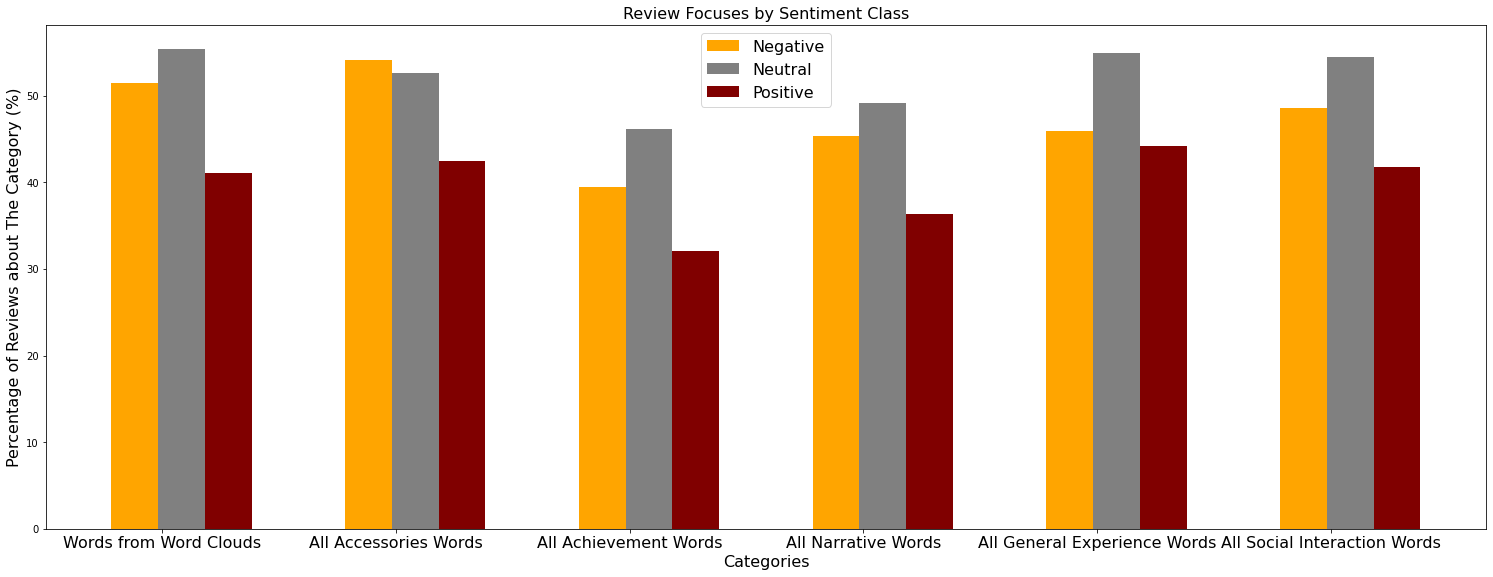

In [255]:
data = [[neg_general_per, neg_acc_per, neg_ach_per, neg_nar_per, neg_ge_per, neg_si_per],
        [neu_general_per, neu_acc_per, neu_ach_per, neu_nar_per, neu_ge_per, neu_si_per],
        [pos_general_per, pos_acc_per, pos_ach_per, pos_nar_per, pos_ge_per, pos_si_per]]
X = np.arange(6)

fig = plt.figure(figsize=(20,7))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.0, data[0], color = 'orange', width = 0.2)
ax.bar(X + 0.2, data[1], color = 'grey', width = 0.2)
ax.bar(X + 0.4, data[2], color = 'maroon', width = 0.2)

plt.xlabel('Categories', fontsize=16)
plt.ylabel('Percentage of Reviews about The Category (%)', fontsize=16)
plt.title('Review Focuses by Sentiment Class', fontsize=16)

plt.xticks(ind + width / 3, ('Words from Word Clouds', 'All Accessories Words', 
                             'All Achievement Words', 'All Narrative Words',
                             'All General Experience Words', 'All Social Interaction Words'), fontsize=16)
ax.legend(['Negative', 'Neutral','Positive'], fontsize=16)

fig.tight_layout()
plt.show();